In [22]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.spatial import distance
from sklearn.utils.multiclass import unique_labels
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, SpectralClustering, MiniBatchKMeans
from sklearn.cluster import DBSCAN, MeanShift, OPTICS, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LassoCV, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.semi_supervised import LabelPropagation, LabelSpreading



from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import StackingClassifier

import warnings
    
# warnings -> to silence warnings

warnings.filterwarnings("ignore")
np.set_printoptions(precision=5, suppress=True)


RANDOM_STATE = 46
N_JOBS = -1

class_names = ["Canis", "Dysg. Equisimilis", "Dysg. Dysgalactiae"]

map_target = {
    "Streptococcus canis": 2,
    "Streptococcus dysgalactiae subsp. dysgalactiae": 1,
    "Streptococcus dysgalactiae subsp. equisimilis": 0
}

map_target_inv = {
    0: "Strept. canis",
    1: "Strept. dysg. dysgalactiae",
    2: "Strept. dysg. equisimilis"
    
}
map_target_antibiotici = {
    "S" : 1,
    "NS" : 0
}

metrics = ['accuracy', 'recall_weighted', 'precision_weighted','f1_weighted']
metrics_cluster = ['Silhouette', 'Calinski', 'Davies']
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

start = 9
n_antibiotici = 9
n_geni = 27
n_virulenza = 18
n = 46

In [23]:
# Load the data
df = pd.read_csv("../data/Dati_Matemaldomics_"+str(n)+"picchi.csv",
                    delimiter=';', index_col='ID Strain')

In [24]:
df['subspecies'] = df["Putative Subspecies"].map(map_target)

feat_agg = df.iloc[:,[7,8]]
display(feat_agg)
st = df.iloc[:,[4]]
display(st)
subspecies = df[['subspecies']]
maldi = df.iloc[:,start:start+n]
antibiotici = df.iloc[:,start+n:start+n+n_antibiotici]
geni_antibiotici = df.iloc[:,start+n+n_antibiotici:start+n+n_antibiotici+n_geni]
virulenza = df.iloc[:,start+n+n_antibiotici+n_geni:start+n+n_antibiotici+n_geni+n_virulenza]

maldi.fillna(0, inplace=True)
maldi = maldi.replace(',', '.', regex=True)
columns = maldi.columns
for column in columns:
    maldi[column] = maldi[column].astype(float)
display(maldi)

targets = {'antibiotici' : antibiotici,
            'geni_antibiotici' : geni_antibiotici,
            'virulenza' : virulenza}

targets_cluster = {
       'subspecies' : subspecies
}

for str_target,target in targets.items():
    columns = target.columns
    for column in columns:
        if str_target == 'antibiotici':
            target[column] = df[column].map(map_target_antibiotici)
        rapporto = (target[column] == 0).sum() / target.shape[0]
        #if (antibiotici[column] == 0).all() or (antibiotici[column] == 1).all():
        print(column+" : "+str(rapporto))
        if rapporto < 0.15 or rapporto > 0.85:
            target.drop([column], axis=1, inplace=True)
            
    display(target)

target['subspecies'] = subspecies

,LANCEFIELD GROUP,Haemolysis
ID Strain,,
V13,G,b
V142,G,b
V151,G,b
V160,G,b
V161,G,b
...,...,...
V800,C,a
V82,G,b
V90,G,b


,ST
ID Strain,
V13,ST13
V142,ST23
V151,ST95
V160,ST15
V161,ST9
...,...
V800,ST307
V82,ST9
V90,ST13


,"2223,140967","2241,073989","2262,75751","2679,802856","2978,296408","3159,441237","3354,28405","3364,608472","3397,909861","3418,174965",...,"9030,351844","9073,208159","9487,183195","10103,20284","10400,80576","10491,16654","10930,54833","13276,73249","14943,03835","15048,89449"
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,0.000665,0.000180,0.000198,0.000059,0.000865,0.000497,0.000197,0.000272,0.000578,0.000198,...,0.000206,0.000133,0.000587,0.000180,0.000065,0.000065,0.000172,0.000076,0.000058,0.000142
V142,0.000648,0.000156,0.000192,0.000400,0.000698,0.000414,0.000684,0.000349,0.000617,0.000494,...,0.000219,0.000205,0.000465,0.000193,0.000142,0.000116,0.000165,0.000067,0.000067,0.000194
V151,0.000545,0.000331,0.000204,0.000277,0.000613,0.000464,0.000279,0.001031,0.000624,0.000409,...,0.000261,0.000263,0.000585,0.000235,0.000198,0.000152,0.000208,0.000084,0.000092,0.000069
V160,0.000509,0.000191,0.000193,0.000266,0.000489,0.000358,0.000628,0.000692,0.000564,0.000611,...,0.000311,0.000312,0.000083,0.000241,0.000242,0.000187,0.000245,0.000082,0.000075,0.000136
V161,0.000517,0.000118,0.000158,0.000163,0.000610,0.000502,0.000621,0.000315,0.000507,0.000638,...,0.000206,0.000224,0.000711,0.000242,0.000156,0.000116,0.000154,0.000093,0.000072,0.000203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,0.000456,0.000253,0.000125,0.000061,0.000586,0.000365,0.000258,0.001095,0.000537,0.000214,...,0.000102,0.000195,0.000843,0.000250,0.000088,0.000109,0.000298,0.000060,0.000073,0.000059
V82,0.000459,0.000121,0.000147,0.000270,0.000571,0.000338,0.000596,0.000321,0.000537,0.000668,...,0.000263,0.000277,0.000452,0.000254,0.000211,0.000162,0.000203,0.000059,0.000070,0.000144
V90,0.000505,0.000154,0.000158,0.000181,0.000610,0.000473,0.000374,0.000525,0.000513,0.000377,...,0.000288,0.000310,0.000671,0.000237,0.000224,0.000185,0.000230,0.000089,0.000080,0.000137


Eritromicina : 0.461038961038961
Ceftiofur : 0.0
Tetraciclina : 0.5194805194805194
Gentamicina : 0.6233766233766234
Penicillina : 0.0
Ampicillina : 0.0
Sulfametossazolo_trimethoprim : 0.01948051948051948
Clindamicina : 0.2662337662337662
Enrofloxacin : 0.6688311688311688


,Eritromicina,Tetraciclina,Gentamicina,Clindamicina,Enrofloxacin
ID Strain,,,,,
V13,0,0,0,1,0
V142,0,1,1,1,0
V151,1,1,0,1,0
V160,1,0,0,1,0
V161,1,1,0,1,0
...,...,...,...,...,...
V800,1,0,1,1,0
V82,1,1,0,1,1
V90,1,0,0,1,0


aad(6) : 0.935064935064935
ANT(6)-Ia : 0.8246753246753247
APH(2'')-IIIa : 1.0
APH(3')-IIIa : 0.9025974025974026
catS : 0.9675324675324676
dfrF : 0.9805194805194806
E. faecalis chloramphenicol acetyltransferase : 0.9935064935064936
Erm(47) : 0.987012987012987
ErmB : 0.8181818181818182
fexA : 0.9935064935064936
L._reuteri cat-TC : 1.0
lmrP : 0.006493506493506494
lnuC : 0.987012987012987
lnuD : 0.9935064935064936
lsaC : 0.961038961038961
lsaE : 0.7857142857142857
mefE : 0.8506493506493507
optrA : 0.9935064935064936
poxtA : 0.9935064935064936
SAT-4 : 0.922077922077922
tet(40) : 0.987012987012987
tet(L) : 0.9935064935064936
tetM : 0.8181818181818182
tetO : 0.7402597402597403
tetS : 0.9805194805194806
tetT : 0.974025974025974
vatE : 0.9935064935064936


,ANT(6)-Ia,ErmB,lsaE,tetM,tetO
ID Strain,,,,,
V13,0,0,0,0,0
V142,0,0,0,0,0
V151,0,0,0,0,0
V160,0,0,0,0,0
V161,0,0,0,0,0
...,...,...,...,...,...
V800,0,0,0,1,0
V82,0,0,0,0,0
V90,0,0,0,0,0


fbp54 : 0.0
gbs0630 : 0.9935064935064936
gbs0631 : 0.9935064935064936
gbs0632 : 0.9935064935064936
hasC : 0.0
lmb : 0.9935064935064936
mf2 : 0.961038961038961
mf3 : 0.6753246753246753
scpA : 0.9935064935064936
sda : 0.8766233766233766
ska : 0.9935064935064936
slo : 0.9935064935064936
smeZ : 0.9935064935064936
spec : 0.974025974025974
speg : 0.9090909090909091
spek : 0.961038961038961
spel : 0.974025974025974
spem : 0.948051948051948


,mf3
ID Strain,
V13,0
V142,1
V151,0
V160,0
V161,1
...,...
V800,0
V82,1
V90,0


In [25]:
# Define a function for standard scaling
def standard_scaler(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Define a function for dimensionality reduction using PCA
def dimensionality_reduction(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_train_pca = pd.DataFrame(X_train_pca)
    X_test_pca = pd.DataFrame(X_test_pca)
    #print(X_train_pca.shape)
    return X_train_pca, X_test_pca

def dimensionality_reduction_cluster(X, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca)
    print(X_pca.shape)
    return X_pca

def makeScoreMeanWithoutNaN(metrics):
    for name, metrica in metrics.items():
        print(name)
        print(metrics[name])
        metrics[name] = metrics[name][~np.isnan(metrics[name])]
        print(metrics[name])
        metrics[name] = np.mean(metrics[name])
        print(metrics[name])
    print(metrics)
    return metrics

In [30]:
N_CLUSTERS = 3
# define the models
models = {
  'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE),
  'Ridge' : RidgeClassifier(random_state=RANDOM_STATE),
  'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
  'K-nn': KNeighborsClassifier(),
  'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
  'BernoulliNB': BernoulliNB(),
  'GaussianNB': GaussianNB(),
  #'NearestCentroid': NearestCentroid()
  'SVC' : SVC(),
  'LinearSVC' : LinearSVC(),
  'LabelPropagation' : LabelPropagation(),
  'LabelSpreading' : LabelSpreading(),
  'SGDClassifier' : SGDClassifier() 
}

models_cluster = {
  'K-means' : KMeans(n_clusters = N_CLUSTERS, random_state=RANDOM_STATE),
  'AgglomerativeClustering' : AgglomerativeClustering(n_clusters = N_CLUSTERS),
  #'DBSCAN' : DBSCAN(),
  #'GaussianMixture' : GaussianMixture(n_components=N_CLUSTERS, random_state=RANDOM_STATE),
  #'OPTICS' : OPTICS()
}

models_base = [
        ('LogisticRegression', LogisticRegression()),
        ('Ridge', RidgeClassifier()),
        ('DecisionTree', DecisionTreeClassifier()),
        ('K-nn', KNeighborsClassifier()),
        ('RandomForest', RandomForestClassifier()),
        ('BernoulliNB', BernoulliNB()),
        ('GaussianNB', GaussianNB()),
]

n_classes = [0,1]
# Hyperparameter tuning using RandomizedSearchCV
param_grid = {
  'LogisticRegression': {'C': np.logspace(-4, 4, 25), 
                        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                        'fit_intercept': [True, False],
                        'intercept_scaling': [0.5, 1, 2],
                        'class_weight': [None, 'balanced']
                        },
  'Ridge' : {'alpha': np.logspace(-5, 5, 75)},
  'DecisionTree': {'ccp_alpha': [0.0] + list(np.logspace(-3, 1, 25)),
                    'class_weight': [None, 'balanced'],
                    'criterion': ['gini', 'entropy', 'log_loss'],
                    'max_depth': [None] + list(range(1, 20)),
                    'max_features': [None, 'auto', 'sqrt', 'log2'],
                    'min_samples_leaf': range(1, 10),
                    'min_samples_split': range(2, 10),
                    'splitter': ['best', 'random']
                    },
  'K-nn': {'n_neighbors': list(range(1, 20, 1)),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1,2]
            },
  'RandomForest': {'ccp_alpha': [0] + list(np.logspace(-3, 1, 25)),
                    'class_weight': [None, 'balanced'],
                    'n_estimators': range(50,500,50),
                    'max_features': [None, 'auto', 'sqrt', 'log2'],
                    'max_depth' : [None,4,6,8,10],
                    'criterion' :['gini', 'entropy']
                    },
  'BernoulliNB': {'alpha': np.logspace(-2, 1, 10),
                'fit_prior': [True, False],
                'class_prior': [None, [0.1,]* len(n_classes)],
                'binarize': [None, -5, -2, 0.0, 2, 5, 10.0]
                },
  'GaussianNB': {'var_smoothing': np.logspace(0,-9, num=20)
                  },
  'NearestCentroid': {'shrink_threshold': np.logspace(0, 1, 20),
                    'metric': ['euclidean', 'manhattan']
                    },
  'SVC': {'C': np.logspace(-4, 4, 25),
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'degree': range(2,5),
          'gamma': np.logspace(-3, 1, 25)},
  'LabelPropagation': {'n_neighbors': [7, 21, 41, 81, 121, 181, 241],
                        'gamma': [0.1, 1, 5, 10, 20, 30, 50]},
  'LabelSpreading': {'n_neighbors': [7, 21, 41, 81, 121, 181, 241],
                    'gamma': [0.1, 1, 5, 10, 20, 30, 50],
                    'alpha': [0.15, 0.2, 0.35, 0.55, 0.75, 0.95]},
  'SGDClassifier': {'loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                'penalty' : ['l1', 'l2', 'elasticnet'],
                'alpha' : np.logspace(-4, 4, 25),
                'learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive'],
                'class_weight' : [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
                'eta0' : [1, 10, 100]},
  'LinearSVC': {'penalty': ['l1', 'l2'],
                'loss': ['hinge', 'squared_hinge'],
                'class_weight': [None, 'balanced']},
  'stack' : {'meta_classifier__C': np.logspace(-4, 4, 25), 
            'meta_classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'meta_classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'meta_classifier__fit_intercept': [True, False],
            'meta_classifier__intercept_scaling': [0.5, 1, 2],
            'meta_classifier__class_weight': [None, 'balanced']
            }
}
param_grid_cluster = {
  'K-means' : list(ParameterGrid({
    'n_clusters': range(2, 6),  # Range of number of clusters
    'init': ['k-means++', 'random'],  # Initialization methods
    'max_iter': range(100, 1001, 100),  # Maximum number of iterations
    'tol': [1e-3, 1e-4, 1e-5],  # Tolerance for convergence
    'algorithm': ['auto', 'full', 'elkan'],  # K-means algorithm type
    'random_state': [None, RANDOM_STATE, 100]  # Random seed for centroid initialization
    })),
  'AgglomerativeClustering' : list(ParameterGrid({
    'n_clusters': range(2, 8),  # Number of clusters
    'linkage': ['ward', 'complete', 'average', 'single'],  # Linkage type
    })),
  'DBSCAN' : list(ParameterGrid({
    'eps': [0.1, 0.5, 1.0],  # Maximum distance between two samples
    'min_samples': [2, 5, 10]  # Minimum number of samples in a neighborhood
    })),
  'GaussianMixture' : list(ParameterGrid({
    'n_components': range(2, 7),  # Number of mixture components
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Covariance type
    'tol': [1e-4, 1e-3, 1e-2]  # Tolerance for convergence
    }))
}

In [27]:
def makeScore(y_test, y_pred):
    score = {}
    
    score['acc'] = accuracy_score(y_test, y_pred)
    score['b_acc'] = balanced_accuracy_score(y_test, y_pred)
    score['st'] = score['acc'].std()
    score['prec'] = precision_score(y_test, y_pred, average='weighted')
    score['rec'] = recall_score(y_test, y_pred, average='weighted')
    score['f1'] = f1_score(y_test, y_pred, average='weighted')
    
    return score

def makeCrossValidation(model, X_train, y_train):
    score = {}
    cv = cross_validate(estimator=model, X=X_train, y=y_train,
                        scoring=metrics, cv=skfold, 
                        n_jobs=N_JOBS, verbose=0)

    score['acc'] = cv.get('test_accuracy').mean()  
    score['st'] = cv.get('test_accuracy').std()
    score['prec'] = cv.get('test_precision_weighted').mean()
    score['rec'] = cv.get('test_recall_weighted').mean()
    score['f1'] = cv.get('test_f1_weighted').mean()
    
    return score

def makeCrossValidationCluster(model, X):
    model.fit(X)
    labels = model.labels_
    '''n_splits = 5
    
    # Create a K-fold cross-validation object
    kf = KFold(n_splits=n_splits)

    # Initialize lists to store the evaluation metric scores
    silhouette_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []

    # Iterate over the cross-validation folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        
        # Fit the clustering model
        model.fit(X_train)
        
        # Obtain cluster labels for test data
        labels = model.labels_
        
        # Calculate evaluation metrics
        silhouette = silhouette_score(X_test, labels)
        calinski_harabasz = calinski_harabasz_score(X_test, labels)
        davies_bouldin = davies_bouldin_score(X_test, labels)
        
        # Append the scores to the respective lists
        silhouette_scores.append(silhouette)
        calinski_harabasz_scores.append(calinski_harabasz)
        davies_bouldin_scores.append(davies_bouldin)

    # Calculate the average scores across all folds
    avg_silhouette = np.mean(silhouette_scores)
    avg_calinski_harabasz = np.mean(calinski_harabasz_scores)
    avg_davies_bouldin = np.mean(davies_bouldin_scores)
    '''
    pca = PCA(n_components = 2)
    pca.fit(X)
    X_pca = pca.transform(X)
    avg_silhouette = silhouette_score(X_pca, labels)
    avg_calinski_harabasz = calinski_harabasz_score(X_pca, labels)
    avg_davies_bouldin = davies_bouldin_score(X_pca, labels)
    '''
    # Print the average scores
    print("Average Silhouette Score:", avg_silhouette)
    print("Average Calinski-Harabasz Score:", avg_calinski_harabasz)
    print("Average Davies-Bouldin Score:", avg_davies_bouldin)
    avg_silhouette = 0
    avg_calinski_harabasz = 0
    avg_davies_bouldin = 0
    '''
    score = {}
    score['Silhouette'] = avg_silhouette
    score['Calinski'] = avg_calinski_harabasz
    score['Davies'] = avg_davies_bouldin

    return score

def makeTuning(model, X_train, y_train, name):
    score = {}
    params = param_grid[name]
    rs = RandomizedSearchCV(estimator=model, param_distributions=params,
                            scoring=metrics, refit="accuracy", cv=skfold, 
                            n_jobs=N_JOBS, random_state=RANDOM_STATE, verbose=0)
    rs.fit(X_train, y_train)
    
    results = rs.cv_results_
    model_best = rs.best_estimator_
    parametri = model.get_params()
    cv_best = rs.best_score_
    
    score = makeCrossValidation(model_best, X_train, y_train)
    
    return clone(model_best), score

def makeTuningCluster(model, X, y, name):
    score = {}
    params = param_grid_cluster[name]
    max = 0
    for param in params:
        #print(param)
        model_cl = clone(model)
        model_cl.set_params(**param)
        model_cl.fit(X)
        y_pred = model_cl.labels_
        score = makeScore(y,y_pred)
        #print(score['acc'])
        if score['acc'] > max:
            max = score['acc']
            model_best = model
            print(max)
            print(model_best.get_params())

    score = makeCrossValidationCluster(model_best, X)
    print(model_best.get_params())
    return clone(model_best), score

In [28]:
#Dataframe per confronto predizioni
score_target_cluster = {}
pred_ensemble_cluster = pd.DataFrame()
pred_ensemble_cluster_best = pd.DataFrame()
pred_ensemble_cluster_pca = pd.DataFrame()
pred_ensemble_cluster_best_pca = pd.DataFrame()

X = maldi
model_obj_cluster = {}

#Per ogni tipologia di target del problema (sottospecie, antibiotici, geni, fattori, st)
for str_target, target in targets_cluster.items():
    columns = target.columns
    #Per ogni tipologia di target scorre tutti i target
    for column in columns:
       print("Target:"+column)    
       y = target[column]
       
       #Lista dei modelli con tuning degli iperparametri
       models_best = list()
       models_best_pca = list()       
       
       #Dataframe con risultati metriche per ogni modello
       metrics_df = pd.DataFrame(columns=['Target', 'Model', 'Accuracy', 'St. Dev.', 
                                   'Precision', 'Recall', 'F1-Score', 'Bal. Accuracy', 
                                   'Silhouette', 'Calinski', 'Davies'])
       
       # split the data into training and testing sets
       X_pca = dimensionality_reduction_cluster(X, n_components=0.95)
       
       # evaluate the models on the original dataset and into the dataset reduced
       dataframes = {'' : X,
                    '_PCA' : X_pca}
       
       #Scorre i modelli nel dizionario dei modelli utilizzati
       for name, model in models_cluster.items():
              #Prima iterazione senza PCA, seconda con PCA
              for pca, dataframe in dataframes.items():
                     print("Modello "+name+pca)
                     X = dataframe
                     
                     #display(X)
                     model_base = clone(model)
                     model_best = clone(model)
                     
                     #Modello base: cross validation with score, fit, predict 
                     score_cluster = makeCrossValidationCluster(model_base, X)
                     model_base.fit(X)
                     y_pred = model_base.labels_
                     
                     #print(y.values)
                     #print(y_pred)
                     score = makeScore(y.values, y_pred)
                     if pca == '':
                            pred_ensemble_cluster[name] = y_pred
                     else:
                            pred_ensemble_cluster_pca[name] = y_pred

                     ris = {'Target': column,
                            'Model': name+pca,
                            'Accuracy' : score['acc'],
                            'St. Dev.' : score['st'],
                            'Precision' : score['prec'],
                            'Recall' : score['rec'],
                            'F1-Score' : score['f1'],
                            'Bal. Accuracy' : score['b_acc'],
                            'Silhouette' : score_cluster['Silhouette'],                          
                            'Calinski' : score_cluster['Calinski'],
                            'Davies' : score_cluster['Davies']}
                     
                     #display(ris)
                     metrics_df = metrics_df.append(ris, ignore_index=True)  
                     model_obj_cluster[column+'_'+name+pca] = model_base
                     
                     '''if  name == 'K-means':
                            plt.scatter(X[:, 0], X[:, 2], c=y_pred, s=50, cmap='viridis')
                            centers = model_base.cluster_centers_
                            plt.scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5)'''
                            
                     #TUNING MODEL
                     model_best, score_cluster = makeTuningCluster(model_best, X, y, name)
                     model_best.fit(X)
                     y_pred = model_best.labels_
                     score = makeScore(y.values, y_pred)
                     
                     if pca == '':
                            models_best.append((name,model_best))
                            pred_ensemble_cluster_best[name] = y_pred
                     else:
                            models_best_pca.append((name,model_best))
                            pred_ensemble_cluster_best_pca[name] = y_pred

                     ris = {'Target': column,
                            'Model': name+'_Best'+pca,
                            'Accuracy' : score['acc'],
                            'St. Dev.' : score['st'],
                            'Precision' : score['prec'],
                            'Recall' : score['rec'],
                            'F1-Score' : score['f1'],
                            'Bal. Accuracy' : score['b_acc'],
                            'Silhouette' : score_cluster['Silhouette'],                           
                            'Calinski' : score_cluster['Calinski'],
                            'Davies' : score_cluster['Davies']}
                     display(ris)
                     metrics_df = metrics_df.append(ris, ignore_index=True)      
                     model_obj_cluster[column+'_'+name+'_Best'+pca] = model_best
                     
       #Aggiunge i valori del target nei dizionari
       pred_ensemble_cluster['Target'] = y.values 
       pred_ensemble_cluster_best['Target'] = y.values
       pred_ensemble_cluster_pca['Target'] = y.values 
       pred_ensemble_cluster_best_pca['Target'] = y.values
       
       #Stampa le predizioni
       display(pred_ensemble_cluster)
       print("Model with tuning")
       display(pred_ensemble_cluster_best)
       print("Model with PCA")
       display(pred_ensemble_cluster_pca)
       print("Model with PCA and tuning")
       display(pred_ensemble_cluster_best_pca)
       
       print('\n')
       score_target_cluster[column] = metrics_df
       #metrics_df.to_csv('..\Risultati\Results_Def_'+str(n)+'picchi\Results_'+column+'_'+str(n)+'.csv', index = False)
       score_target_cluster[column].set_index('Model', inplace = True)
       display(score_target_cluster[column])
print("Modelli:")
print(model_obj_cluster)

df_cluster = pred_ensemble_cluster_best

Target:subspecies
(154, 13)
Modello K-means
{'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10, 'random_state': 46, 'tol': 0.0001, 'verbose': 0}


{'Target': 'subspecies',
 'Model': 'K-means_Best',
 'Accuracy': 0.9025974025974026,
 'St. Dev.': 0.0,
 'Precision': 0.9048789048789049,
 'Recall': 0.9025974025974026,
 'F1-Score': 0.8998944145285609,
 'Bal. Accuracy': 0.893361285814116,
 'Silhouette': 0.592149157317064,
 'Calinski': 320.323586670263,
 'Davies': 0.5985071697653699}

Modello K-means_PCA
{'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10, 'random_state': 46, 'tol': 0.0001, 'verbose': 0}


{'Target': 'subspecies',
 'Model': 'K-means_Best_PCA',
 'Accuracy': 0.9025974025974026,
 'St. Dev.': 0.0,
 'Precision': 0.9048789048789049,
 'Recall': 0.9025974025974026,
 'F1-Score': 0.8998944145285609,
 'Bal. Accuracy': 0.893361285814116,
 'Silhouette': 0.592149157317064,
 'Calinski': 320.3235866702627,
 'Davies': 0.5985071697653702}

Modello AgglomerativeClustering
{'affinity': 'euclidean', 'compute_distances': False, 'compute_full_tree': 'auto', 'connectivity': None, 'distance_threshold': None, 'linkage': 'ward', 'memory': None, 'n_clusters': 3}


{'Target': 'subspecies',
 'Model': 'AgglomerativeClustering_Best',
 'Accuracy': 0.948051948051948,
 'St. Dev.': 0.0,
 'Precision': 0.9477407990259887,
 'Recall': 0.948051948051948,
 'F1-Score': 0.9477027660274403,
 'Bal. Accuracy': 0.944095038434661,
 'Silhouette': 0.5401164638548596,
 'Calinski': 257.74449212788096,
 'Davies': 0.7449953175583331}

Modello AgglomerativeClustering_PCA
{'affinity': 'euclidean', 'compute_distances': False, 'compute_full_tree': 'auto', 'connectivity': None, 'distance_threshold': None, 'linkage': 'ward', 'memory': None, 'n_clusters': 3}


{'Target': 'subspecies',
 'Model': 'AgglomerativeClustering_Best_PCA',
 'Accuracy': 0.4090909090909091,
 'St. Dev.': 0.0,
 'Precision': 0.37216565385579475,
 'Recall': 0.4090909090909091,
 'F1-Score': 0.3871358258241919,
 'Bal. Accuracy': 0.41076170510132776,
 'Silhouette': 0.5888511989334877,
 'Calinski': 280.6284600118496,
 'Davies': 0.5455588502975699}

,K-means,AgglomerativeClustering,Target
0,0,2,2
1,2,2,2
2,1,0,2
3,2,2,2
4,2,2,2
...,...,...,...
149,1,1,1
150,2,2,2
151,2,2,2
152,2,2,2


Model with tuning


,K-means,AgglomerativeClustering,Target
0,0,2,2
1,2,2,2
2,1,0,2
3,2,2,2
4,2,2,2
...,...,...,...
149,1,1,1
150,2,2,2
151,2,2,2
152,2,2,2


Model with PCA


,K-means,AgglomerativeClustering,Target
0,0,2,2
1,2,2,2
2,1,0,2
3,2,2,2
4,2,2,2
...,...,...,...
149,1,0,1
150,2,2,2
151,2,2,2
152,2,2,2


Model with PCA and tuning


,K-means,AgglomerativeClustering,Target
0,0,2,2
1,2,2,2
2,1,0,2
3,2,2,2
4,2,2,2
...,...,...,...
149,1,0,1
150,2,2,2
151,2,2,2
152,2,2,2


,Target,Accuracy,St. Dev.,Precision,Recall,F1-Score,Bal. Accuracy,Silhouette,Calinski,Davies
Model,,,,,,,,,,
K-means,subspecies,0.902597,0.0,0.904879,0.902597,0.899894,0.893361,0.592149,320.323587,0.598507
K-means_Best,subspecies,0.902597,0.0,0.904879,0.902597,0.899894,0.893361,0.592149,320.323587,0.598507
K-means_PCA,subspecies,0.902597,0.0,0.904879,0.902597,0.899894,0.893361,0.592149,320.323587,0.598507
K-means_Best_PCA,subspecies,0.902597,0.0,0.904879,0.902597,0.899894,0.893361,0.592149,320.323587,0.598507
AgglomerativeClustering,subspecies,0.948052,0.0,0.947741,0.948052,0.947703,0.944095,0.540116,257.744492,0.744995
AgglomerativeClustering_Best,subspecies,0.948052,0.0,0.947741,0.948052,0.947703,0.944095,0.540116,257.744492,0.744995
AgglomerativeClustering_PCA,subspecies,0.409091,0.0,0.372166,0.409091,0.387136,0.410762,0.588851,280.628460,0.545559
AgglomerativeClustering_Best_PCA,subspecies,0.409091,0.0,0.372166,0.409091,0.387136,0.410762,0.588851,280.628460,0.545559


Modelli:
{'subspecies_K-means': KMeans(n_clusters=3, random_state=46), 'subspecies_K-means_Best': KMeans(n_clusters=3, random_state=46), 'subspecies_K-means_PCA': KMeans(n_clusters=3, random_state=46), 'subspecies_K-means_Best_PCA': KMeans(n_clusters=3, random_state=46), 'subspecies_AgglomerativeClustering': AgglomerativeClustering(n_clusters=3), 'subspecies_AgglomerativeClustering_Best': AgglomerativeClustering(n_clusters=3), 'subspecies_AgglomerativeClustering_PCA': AgglomerativeClustering(n_clusters=3), 'subspecies_AgglomerativeClustering_Best_PCA': AgglomerativeClustering(n_clusters=3)}


In [34]:

df_clusters = pd.read_csv("../data/clusters_IZSUM.csv",
                    sep=';', index_col = 'ID Strain')
df['subspecies'] = df["Putative Subspecies"].map(map_target)

df = pd.concat([df, df_clusters], axis=1)
display(df)

feat_agg = df.iloc[:,[2,7,8]]
display(feat_agg)
st = df.iloc[:,[4]]
display(st)
subspecies = df[['subspecies']]
maldi = df.iloc[:,start:start+n]
antibiotici = df.iloc[:,start+n:start+n+n_antibiotici]
geni_antibiotici = df.iloc[:,start+n+n_antibiotici:start+n+n_antibiotici+n_geni]
virulenza = df.iloc[:,start+n+n_antibiotici+n_geni:start+n+n_antibiotici+n_geni+n_virulenza]

maldi.fillna(0, inplace=True)
maldi = maldi.replace(',', '.', regex=True)
columns = maldi.columns
for column in columns:
    maldi[column] = maldi[column].astype(float)
display(maldi)

clusters = pd.DataFrame.from_dict(pd.get_dummies(clusters))
display(clusters)

feat_agg = pd.DataFrame.from_dict(pd.get_dummies(feat_agg))
display(feat_agg)

df_X = pd.concat([maldi, clusters, feat_agg], axis=1)
df_X


,Year,Region,Animal species of origin,Organ of origin,ST,Species,Putative Subspecies,LANCEFIELD GROUP,Haemolysis,"2223,140967",...,spek,spel,spem,subspecies,K-means,AgglomerativeClustering,Target,K-means,AgglomerativeClustering,Target
V13,ante 2004,NaN,Dog,Urine,ST13,Streptococcus_canis,Streptococcus canis,G,b,"0,000664776",...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
V142,2008,NaN,Dog,Urine,ST23,Streptococcus_canis,Streptococcus canis,G,b,"0,000647775",...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
V151,2008,NaN,Dog,Ear,ST95,Streptococcus_canis,Streptococcus canis,G,b,"0,000545034",...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
V160,2011,NaN,Dog,Skin,ST15,Streptococcus_canis,Streptococcus canis,G,b,"0,000509415",...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
V161,2011,NaN,Cat,Lung,ST9,Streptococcus_canis,Streptococcus canis,G,b,"0,000516653",...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0
150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0
151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0
152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0


,K-means,AgglomerativeClustering,Target
0,0,2,2
1,2,2,2
2,1,0,2
3,2,2,2
4,2,2,2
...,...,...,...
149,1,1,1
150,2,2,2
151,2,2,2
152,2,2,2


,LANCEFIELD GROUP_A,LANCEFIELD GROUP_C,LANCEFIELD GROUP_G,Haemolysis_a,Haemolysis_b,Haemolysis_b
ID Strain,,,,,,
V13,0,0,1,0,1,0
V142,0,0,1,0,1,0
V151,0,0,1,0,1,0
V160,0,0,1,0,1,0
V161,0,0,1,0,1,0
...,...,...,...,...,...,...
V800,0,1,0,1,0,0
V82,0,0,1,0,1,0
V90,0,0,1,0,1,0


,"2223,140967","2241,073989","2262,75751","2679,802856","2978,296408","3159,441237","3354,28405","3364,608472","3397,909861","3418,174965",...,"15048,89449",K-means,AgglomerativeClustering,Target,LANCEFIELD GROUP_A,LANCEFIELD GROUP_C,LANCEFIELD GROUP_G,Haemolysis_a,Haemolysis_b,Haemolysis_b
V13,0.000665,0.000180,0.000198,0.000059,0.000865,0.000497,0.000197,0.000272,0.000578,0.000198,...,0.000142,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0
V142,0.000648,0.000156,0.000192,0.000400,0.000698,0.000414,0.000684,0.000349,0.000617,0.000494,...,0.000194,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0
V151,0.000545,0.000331,0.000204,0.000277,0.000613,0.000464,0.000279,0.001031,0.000624,0.000409,...,0.000069,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0
V160,0.000509,0.000191,0.000193,0.000266,0.000489,0.000358,0.000628,0.000692,0.000564,0.000611,...,0.000136,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0
V161,0.000517,0.000118,0.000158,0.000163,0.000610,0.000502,0.000621,0.000315,0.000507,0.000638,...,0.000203,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#Dataframe per confronto predizioni
score_target = {}
pred_ensemble = pd.DataFrame()
pred_ensemble_best = pd.DataFrame()
pred_ensemble_pca = pd.DataFrame()
pred_ensemble_best_pca = pd.DataFrame()

dfs = {'' : maldi,
       'cluster' : df_cluster,
       'cluster_dummies' : df_clusters_dummies,
       'agg' : df_agg,
       'maldi+cluster+agg' : df_cluster_agg}

model_obj = {}
for str_df, X in dfs.items():
       #Per ogni tipologia di target del problema (sottospecie, antibiotici, geni, fattori, st)
       for str_target, target in targets.items():
       columns = target.columns
       #Per ogni tipologia di target scorre tutti i target
       for column in columns:
              print("Colonna:"+column)    
              y = target[column]
              
              #Lista dei modelli con tuning degli iperparametri
              models_best = list()
              models_best_pca = list()       
              
              #Dataframe con risultati metriche per ogni modello
              metrics_df = pd.DataFrame(columns=['Target', 'Model', 'Accuracy CV', 'St. Dev. CV', 
                                          'Precision CV', 'Recall CV','F1-Score CV','Accuracy','Bal. Accuracy'])
              
              #parameter range for BernoulliNB in base of the number of classes in the target
              n_classes = np.unique(y)
              param_grid['BernoulliNB']['class_prior'] = [None, [0.1,]* len(n_classes)]
              
              # split the data into training and testing sets
              X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
              X_pca_train, X_pca_test = dimensionality_reduction(X_train, X_test, n_components=0.95)
              
              # evaluate the models on the original dataset and into the dataset reduced
              dataframes = {'' : (X_train, X_test),
                     '_PCA' : (X_pca_train, X_pca_test)}
              
              #Modello di stacking della libreria mlxtend
              '''stack = StackingCVClassifier(classifiers = list(models.values()),
                                          shuffle = False,
                                          use_probas = False,
                                          cv = 5,
                                          meta_classifier = models['SVC'])'''
              
              #models['stack'] = stack
              #models['stack2'] = stack
              
              #Scorre i modelli nel dizionario dei modelli utilizzati
              for name, model in models.items():
                     #Prima iterazione senza PCA, seconda con PCA
                     for pca, dataframe in dataframes.items():
                            #print("Modello "+name+pca)
                            
                            X_train = dataframe[0]
                            X_test = dataframe[1]
                            
                            #Modello di stacking di sklearn
                            if name == 'stack2':
                                   final_model = LogisticRegression()                 
                                   stack2 = StackingClassifier(estimators=models_base, final_estimator=final_model)
                                   score_cv = makeCrossValidation(stack2, X_train, y_train)
                                   stack2.fit(X_train, y_train)
                                   y_pred = stack2.predict(X_test)
                                   score = makeScore(y_test, y_pred)
                                   
                                   #Salva i risultati delle metriche nel dataframe
                                   ris = {'Target': column,
                                          'Model': name+pca,
                                          'Accuracy CV' : score_cv['acc'],
                                          'St. Dev. CV' : score_cv['st'],
                                          'Precision CV' : score_cv['prec'],
                                          'Recall CV' : score_cv['rec'],
                                          'F1-Score CV' : score_cv['f1'],
                                          'Accuracy' : score['acc'],
                                          'Bal. Accuracy' : score['b_acc']} 
                                   #display(ris)
                                   metrics_df = metrics_df.append(ris, ignore_index=True)
                                   model_obj[column+'_'+name+pca] = stack2
                                   #TUNING MODEL STACKING, utilizza i modelli dove è gia stato fatto il tuning degli iperparametri
                                   final_model = LogisticRegression()

                                   if pca == '':
                                          pred_ensemble[name] = y_pred
                                          #print(models_best)
                                          stack2_best = StackingClassifier(estimators=models_best, final_estimator=final_model)
                                   else:
                                          pred_ensemble_pca[name] = y_pred
                                          #print(models_best_pca)
                                          stack2_best = StackingClassifier(estimators=models_best_pca, final_estimator=final_model)
                                   stack2_best = stack2_best.fit(X_train, y_train)
                                   score_cv = makeCrossValidation(stack2_best, X_train, y_train)
                                   
                                   stack2_best.predict(X_test)
                                   score = makeScore(y_test, y_pred)
                                   
                                   ris = {'Target': column,
                                          'Model': name+'_Best'+pca,
                                          'Accuracy CV' : score_cv['acc'],
                                          'St. Dev. CV' : score_cv['st'],
                                          'Precision CV' : score_cv['prec'],
                                          'Recall CV' : score_cv['rec'],
                                          'F1-Score CV' : score_cv['f1'],
                                          'Accuracy' : score['acc'],
                                          'Bal. Accuracy' : score['b_acc']} 
                                   #display(ris)
                                   metrics_df = metrics_df.append(ris, ignore_index=True)
                                   model_obj[column+'_'+name+'_Best'+pca] = stack2_best
                                   
                                   #Salva nel dizionario le predizioni del modello
                                   if pca == '':
                                          pred_ensemble_best[name] = y_pred
                                   else:
                                          pred_ensemble_best_pca[name] = y_pred
                            
                            #Per tutti gli altri modelli       
                            else:
                                   model_base = model
                                   model_best = model
                                   
                                   #Modello base: cross validation with score, fit, predict 
                                   score_cv = makeCrossValidation(model_base, X_train, y_train)
                                   '''if name == 'stack':
                                          score_cv['acc'] = model_selection.cross_val_score(stack, X_train, y_train, cv = 5, scoring='accuracy').mean()'''
                                   model_base.fit(X_train, y_train)
                                   y_pred = model_base.predict(X_test)
                                   
                                   score = makeScore(y_test, y_pred)
                                   if pca == '':
                                          pred_ensemble[name] = y_pred
                                   else:
                                          pred_ensemble_pca[name] = y_pred
              
                                   ris = {'Target': column,
                                          'Model': name+pca,
                                          'Accuracy CV' : score_cv['acc'],
                                          'St. Dev. CV' : score_cv['st'],
                                          'Precision CV' : score_cv['prec'],
                                          'Recall CV' : score_cv['rec'],
                                          'F1-Score CV' : score_cv['f1'],
                                          'Accuracy' : score['acc'],
                                          'Bal. Accuracy' : score['b_acc']}
                                   
                                   #display(ris)
                                   metrics_df = metrics_df.append(ris, ignore_index=True)  
                                   model_obj[column+'_'+name+pca] = model_base
                                   
                                   #TUNING MODEL
                                   model_best, score_cv = makeTuning(model_best, X_train, y_train, name)

                                   if name != 'stack':
                                          if pca == '':
                                                 models_best.append((name,model_best))
                                          else:
                                                 models_best_pca.append((name,model_best))
                                   model_best.fit(X_train, y_train)
                                   y_pred = model_best.predict(X_test)
                                   
                                   score = makeScore(y_test, y_pred)
                                   if pca == '':
                                          pred_ensemble_best[name] = y_pred
                                   else:
                                          pred_ensemble_best_pca[name] = y_pred

                                   ris = {'Target': column,
                                          'Model': name+'_Best'+pca,
                                          'Accuracy CV' : score_cv['acc'],
                                          'St. Dev. CV' : score_cv['st'],
                                          'Precision CV' : score_cv['prec'],
                                          'Recall CV' : score_cv['rec'],
                                          'F1-Score CV' : score_cv['f1'],
                                          'Accuracy' : score['acc'],
                                          'Bal. Accuracy' : score['b_acc']} 
                                   #display(ris)
                                   metrics_df = metrics_df.append(ris, ignore_index=True)      
                                   model_obj[column+'_'+name+'_Best'+pca] = model_best
       #Aggiunge i valori del target nei dizionari
       pred_ensemble['Target'] = y_test.values 
       pred_ensemble_best['Target'] = y_test.values
       pred_ensemble_pca['Target'] = y_test.values 
       pred_ensemble_best_pca['Target'] = y_test.values
       
       #Stampa le predizioni
       '''display(pred_ensemble)
       print("Model with tuning")
       display(pred_ensemble_best)
       print("Model with PCA")
       display(pred_ensemble_pca)
       print("Model with PCA and tuning")
       display(pred_ensemble_best_pca)'''
       
       print('\n')
       score_target[column] = metrics_df
       #metrics_df.to_csv('..\Risultati\Results_Def_'+str(n)+'picchi\Results_'+column+'_'+str(n)+'.csv', index = False)
       score_target[column].set_index('Model', inplace = True)
       display(score_target[column])
print("Modelli:")
print(model_obj)

Colonna:Eritromicina




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,Eritromicina,0.520333,0.013182,0.270921,0.520333,0.356266,0.612903,0.500000
LogisticRegression_Best,Eritromicina,0.659667,0.069908,0.680019,0.659667,0.653120,0.548387,0.600877
LogisticRegression_PCA,Eritromicina,0.520333,0.013182,0.270921,0.520333,0.356266,0.612903,0.500000
LogisticRegression_Best_PCA,Eritromicina,0.651333,0.055442,0.655919,0.651333,0.650821,0.548387,0.585526
Ridge,Eritromicina,0.520333,0.013182,0.270921,0.520333,0.356266,0.612903,0.500000
Ridge_Best,Eritromicina,0.529000,0.049144,0.563673,0.529000,0.480826,0.548387,0.554825
Ridge_PCA,Eritromicina,0.520333,0.013182,0.270921,0.520333,0.356266,0.612903,0.500000
Ridge_Best_PCA,Eritromicina,0.529000,0.049144,0.563673,0.529000,0.480826,0.548387,0.554825
DecisionTree,Eritromicina,0.544333,0.070865,0.547959,0.544333,0.540440,0.548387,0.585526


Colonna:Tetraciclina




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,Tetraciclina,0.512000,0.009798,0.262240,0.512000,0.346807,0.548387,0.500000
LogisticRegression_Best,Tetraciclina,0.649667,0.069733,0.657634,0.649667,0.643774,0.806452,0.792017
LogisticRegression_PCA,Tetraciclina,0.512000,0.009798,0.262240,0.512000,0.346807,0.548387,0.500000
LogisticRegression_Best_PCA,Tetraciclina,0.657667,0.082970,0.663556,0.657667,0.652586,0.806452,0.792017
Ridge,Tetraciclina,0.512000,0.009798,0.262240,0.512000,0.346807,0.548387,0.500000
Ridge_Best,Tetraciclina,0.593333,0.027588,0.620565,0.593333,0.568983,0.774194,0.756303
Ridge_PCA,Tetraciclina,0.512000,0.009798,0.262240,0.512000,0.346807,0.548387,0.500000
Ridge_Best_PCA,Tetraciclina,0.593333,0.027588,0.620565,0.593333,0.568983,0.774194,0.756303
DecisionTree,Tetraciclina,0.618000,0.140228,0.623292,0.618000,0.615307,0.677419,0.680672


Colonna:Gentamicina




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,Gentamicina,0.601667,0.013333,0.362181,0.601667,0.452119,0.709677,0.500000
LogisticRegression_Best,Gentamicina,0.650333,0.070635,0.653050,0.650333,0.649888,0.741935,0.785354
LogisticRegression_PCA,Gentamicina,0.601667,0.013333,0.362181,0.601667,0.452119,0.709677,0.500000
LogisticRegression_Best_PCA,Gentamicina,0.650333,0.070635,0.653050,0.650333,0.649888,0.741935,0.785354
Ridge,Gentamicina,0.601667,0.013333,0.362181,0.601667,0.452119,0.709677,0.500000
Ridge_Best,Gentamicina,0.601667,0.013333,0.362181,0.601667,0.452119,0.709677,0.500000
Ridge_PCA,Gentamicina,0.601667,0.013333,0.362181,0.601667,0.452119,0.709677,0.500000
Ridge_Best_PCA,Gentamicina,0.601667,0.013333,0.362181,0.601667,0.452119,0.709677,0.500000
DecisionTree,Gentamicina,0.569000,0.084509,0.575992,0.569000,0.568190,0.580645,0.573232


Colonna:Clindamicina




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,Clindamicina,0.740000,0.016733,0.547880,0.740000,0.629532,0.709677,0.500000
LogisticRegression_Best,Clindamicina,0.813333,0.089144,0.768242,0.813333,0.768367,0.806452,0.699495
LogisticRegression_PCA,Clindamicina,0.740000,0.016733,0.547880,0.740000,0.629532,0.709677,0.500000
LogisticRegression_Best_PCA,Clindamicina,0.844333,0.072584,0.849695,0.844333,0.843475,0.806452,0.765152
Ridge,Clindamicina,0.740000,0.016733,0.547880,0.740000,0.629532,0.709677,0.500000
Ridge_Best,Clindamicina,0.740000,0.016733,0.547880,0.740000,0.629532,0.709677,0.500000
Ridge_PCA,Clindamicina,0.740000,0.016733,0.547880,0.740000,0.629532,0.709677,0.500000
Ridge_Best_PCA,Clindamicina,0.740000,0.016733,0.547880,0.740000,0.629532,0.709677,0.500000
DecisionTree,Clindamicina,0.804333,0.061677,0.833916,0.804333,0.798351,0.645161,0.553030


Colonna:Enrofloxacin




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,Enrofloxacin,0.732000,0.014697,0.536040,0.732000,0.618817,0.419355,0.500000
LogisticRegression_Best,Enrofloxacin,0.732000,0.014697,0.536040,0.732000,0.618817,0.419355,0.500000
LogisticRegression_PCA,Enrofloxacin,0.732000,0.014697,0.536040,0.732000,0.618817,0.419355,0.500000
LogisticRegression_Best_PCA,Enrofloxacin,0.732000,0.014697,0.536040,0.732000,0.618817,0.419355,0.500000
Ridge,Enrofloxacin,0.732000,0.014697,0.536040,0.732000,0.618817,0.419355,0.500000
Ridge_Best,Enrofloxacin,0.732000,0.014697,0.536040,0.732000,0.618817,0.419355,0.500000
Ridge_PCA,Enrofloxacin,0.732000,0.014697,0.536040,0.732000,0.618817,0.419355,0.500000
Ridge_Best_PCA,Enrofloxacin,0.732000,0.014697,0.536040,0.732000,0.618817,0.419355,0.500000
DecisionTree,Enrofloxacin,0.585667,0.094596,0.604512,0.585667,0.587017,0.645161,0.673077


Colonna:ANT(6)-Ia




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,ANT(6)-Ia,0.829333,0.014967,0.688018,0.829333,0.752035,0.806452,0.500000
LogisticRegression_Best,ANT(6)-Ia,0.878000,0.025417,0.886222,0.878000,0.876644,0.903226,0.813333
LogisticRegression_PCA,ANT(6)-Ia,0.829333,0.014967,0.688018,0.829333,0.752035,0.806452,0.500000
LogisticRegression_Best_PCA,ANT(6)-Ia,0.844667,0.056631,0.867253,0.844667,0.852166,0.870968,0.856667
Ridge,ANT(6)-Ia,0.829333,0.014967,0.688018,0.829333,0.752035,0.806452,0.500000
Ridge_Best,ANT(6)-Ia,0.829333,0.014967,0.688018,0.829333,0.752035,0.806452,0.500000
Ridge_PCA,ANT(6)-Ia,0.829333,0.014967,0.688018,0.829333,0.752035,0.806452,0.500000
Ridge_Best_PCA,ANT(6)-Ia,0.829333,0.014967,0.688018,0.829333,0.752035,0.806452,0.500000
DecisionTree,ANT(6)-Ia,0.861667,0.054630,0.857189,0.861667,0.857973,0.774194,0.606667


Colonna:ErmB




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,ErmB,0.813333,0.016330,0.661778,0.813333,0.729697,0.838710,0.500000
LogisticRegression_Best,ErmB,0.829333,0.029394,0.736197,0.829333,0.774860,0.870968,0.761538
LogisticRegression_PCA,ErmB,0.813333,0.016330,0.661778,0.813333,0.729697,0.838710,0.500000
LogisticRegression_Best_PCA,ErmB,0.821000,0.060292,0.844422,0.821000,0.825988,0.870968,0.761538
Ridge,ErmB,0.813333,0.016330,0.661778,0.813333,0.729697,0.838710,0.500000
Ridge_Best,ErmB,0.813333,0.016330,0.661778,0.813333,0.729697,0.838710,0.500000
Ridge_PCA,ErmB,0.813333,0.016330,0.661778,0.813333,0.729697,0.838710,0.500000
Ridge_Best_PCA,ErmB,0.813333,0.016330,0.661778,0.813333,0.729697,0.838710,0.500000
DecisionTree,ErmB,0.747333,0.083915,0.777960,0.747333,0.755865,0.774194,0.703846


Colonna:lsaE




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,lsaE,0.796667,0.004082,0.634694,0.796667,0.706512,0.741935,0.500000
LogisticRegression_Best,lsaE,0.910333,0.017714,0.916697,0.910333,0.906892,0.838710,0.728261
LogisticRegression_PCA,lsaE,0.796667,0.004082,0.634694,0.796667,0.706512,0.741935,0.500000
LogisticRegression_Best_PCA,lsaE,0.862000,0.053722,0.884444,0.862000,0.863587,0.258065,0.500000
Ridge,lsaE,0.796667,0.004082,0.634694,0.796667,0.706512,0.741935,0.500000
Ridge_Best,lsaE,0.796667,0.004082,0.634694,0.796667,0.706512,0.741935,0.500000
Ridge_PCA,lsaE,0.796667,0.004082,0.634694,0.796667,0.706512,0.741935,0.500000
Ridge_Best_PCA,lsaE,0.796667,0.004082,0.634694,0.796667,0.706512,0.741935,0.500000
DecisionTree,lsaE,0.821000,0.032789,0.824352,0.821000,0.817325,0.709677,0.682065


Colonna:tetM




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,tetM,0.845667,0.014892,0.715374,0.845667,0.775022,0.709677,0.500000
LogisticRegression_Best,tetM,0.845667,0.014892,0.715374,0.845667,0.775022,0.709677,0.500000
LogisticRegression_PCA,tetM,0.845667,0.014892,0.715374,0.845667,0.775022,0.709677,0.500000
LogisticRegression_Best_PCA,tetM,0.845667,0.014892,0.715374,0.845667,0.775022,0.709677,0.500000
Ridge,tetM,0.845667,0.014892,0.715374,0.845667,0.775022,0.709677,0.500000
Ridge_Best,tetM,0.845667,0.014892,0.715374,0.845667,0.775022,0.709677,0.500000
Ridge_PCA,tetM,0.845667,0.014892,0.715374,0.845667,0.775022,0.709677,0.500000
Ridge_Best_PCA,tetM,0.845667,0.014892,0.715374,0.845667,0.775022,0.709677,0.500000
DecisionTree,tetM,0.787667,0.072308,0.839821,0.787667,0.801888,0.709677,0.598485


Colonna:tetO




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,tetO,0.732000,0.014697,0.536040,0.732000,0.618817,0.774194,0.500000
LogisticRegression_Best,tetO,0.772667,0.029676,0.761034,0.772667,0.706057,0.806452,0.672619
LogisticRegression_PCA,tetO,0.732000,0.014697,0.536040,0.732000,0.618817,0.774194,0.500000
LogisticRegression_Best_PCA,tetO,0.732000,0.014697,0.536040,0.732000,0.618817,0.774194,0.500000
Ridge,tetO,0.732000,0.014697,0.536040,0.732000,0.618817,0.774194,0.500000
Ridge_Best,tetO,0.732000,0.014697,0.536040,0.732000,0.618817,0.774194,0.500000
Ridge_PCA,tetO,0.732000,0.014697,0.536040,0.732000,0.618817,0.774194,0.500000
Ridge_Best_PCA,tetO,0.732000,0.014697,0.536040,0.732000,0.618817,0.774194,0.500000
DecisionTree,tetO,0.780667,0.083137,0.773221,0.780667,0.775160,0.838710,0.744048


Colonna:mf3




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,mf3,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000
LogisticRegression_Best,mf3,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000
LogisticRegression_PCA,mf3,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000
LogisticRegression_Best_PCA,mf3,0.705333,0.110047,0.775603,0.705333,0.710607,0.580645,0.593182
Ridge,mf3,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000
Ridge_Best,mf3,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000
Ridge_PCA,mf3,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000
Ridge_Best_PCA,mf3,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000
DecisionTree,mf3,0.681333,0.105596,0.696703,0.681333,0.684049,0.709677,0.693182


Colonna:subspecies




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,subspecies,0.432667,0.137956,0.207433,0.432667,0.273217,0.258065,0.333333
LogisticRegression_Best,subspecies,0.934333,0.055514,0.939176,0.934333,0.933915,0.935484,0.939394
LogisticRegression_PCA,subspecies,0.432667,0.137956,0.207433,0.432667,0.273217,0.258065,0.333333
LogisticRegression_Best_PCA,subspecies,0.927000,0.047707,0.932048,0.927000,0.926929,0.935484,0.939394
Ridge,subspecies,0.432667,0.137956,0.207433,0.432667,0.273217,0.258065,0.333333
Ridge_Best,subspecies,0.748333,0.026916,0.771107,0.748333,0.675120,0.741935,0.757576
Ridge_PCA,subspecies,0.432667,0.137956,0.207433,0.432667,0.273217,0.258065,0.333333
Ridge_Best_PCA,subspecies,0.748333,0.026916,0.771107,0.748333,0.675120,0.741935,0.757576
DecisionTree,subspecies,0.927333,0.053183,0.935130,0.927333,0.925852,0.967742,0.972222


Modelli:
{'Eritromicina_LogisticRegression': LogisticRegression(random_state=46), 'Eritromicina_LogisticRegression_Best': LogisticRegression(C=10.0, class_weight='balanced', fit_intercept=False,
                   intercept_scaling=0.5, random_state=46, solver='liblinear'), 'Eritromicina_LogisticRegression_PCA': LogisticRegression(random_state=46), 'Eritromicina_LogisticRegression_Best_PCA': LogisticRegression(C=2154.4346900318824, class_weight='balanced',
                   penalty='none', random_state=46), 'Eritromicina_Ridge': RidgeClassifier(random_state=46), 'Eritromicina_Ridge_Best': RidgeClassifier(alpha=0.0002245697995539774, random_state=46), 'Eritromicina_Ridge_PCA': RidgeClassifier(random_state=46), 'Eritromicina_Ridge_Best_PCA': RidgeClassifier(alpha=0.0002245697995539774, random_state=46), 'Eritromicina_DecisionTree': DecisionTreeClassifier(random_state=46), 'Eritromicina_DecisionTree_Best': DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=6,
        

In [ ]:
#Dataframe per confronto predizioni
score_target = {}
pred_ensemble = pd.DataFrame()
pred_ensemble_best = pd.DataFrame()
pred_ensemble_pca = pd.DataFrame()
pred_ensemble_best_pca = pd.DataFrame()

X = df_X

#Per ogni tipologia di target del problema (sottospecie, antibiotici, geni, fattori, st)
for str_target, target in targets.items():
    columns = target.columns
    #Per ogni tipologia di target scorre tutti i target
    for column in columns:
       print("Colonna:"+column)    
       y = target[column]
       
       #Lista dei modelli con tuning degli iperparametri
       models_best = list()
       models_best_pca = list()       
       
       #Dataframe con risultati metriche per ogni modello
       metrics_df = pd.DataFrame(columns=['Target', 'Model', 'Accuracy CV', 'St. Dev. CV', 
                                   'Precision CV', 'Recall CV','F1-Score CV','Accuracy','Bal. Accuracy'])
       
       #parameter range for BernoulliNB in base of the number of classes in the target
       n_classes = np.unique(y)
       param_grid['BernoulliNB']['class_prior'] = [None, [0.1,]* len(n_classes)]
       
       # split the data into training and testing sets
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
       X_pca_train, X_pca_test = dimensionality_reduction(X_train, X_test, n_components=0.95)
       
       # evaluate the models on the original dataset and into the dataset reduced
       dataframes = {'' : (X_train, X_test),
                    '_PCA' : (X_pca_train, X_pca_test)}
       
       #Modello di stacking della libreria mlxtend
       '''stack = StackingCVClassifier(classifiers = list(models.values()),
                                   shuffle = False,
                                   use_probas = False,
                                   cv = 5,
                                   meta_classifier = models['SVC'])'''
       
       #models['stack'] = stack
       #models['stack2'] = stack
       
       #Scorre i modelli nel dizionario dei modelli utilizzati
       for name, model in models.items():
              #Prima iterazione senza PCA, seconda con PCA
              for pca, dataframe in dataframes.items():
                     print("Modello "+name+pca)
                     
                     X_train = dataframe[0]
                     X_test = dataframe[1]
                     
                     #Modello di stacking di sklearn
                     if name == 'stack2':
                            final_model = LogisticRegression()                 
                            stack2 = StackingClassifier(estimators=models_base, final_estimator=final_model)
                            score_cv = makeCrossValidation(stack2, X_train, y_train)
                            stack2.fit(X_train, y_train)
                            y_pred = stack2.predict(X_test)
                            score = makeScore(y_test, y_pred)
                            
                            #Salva i risultati delle metriche nel dataframe
                            ris = {'Target': column,
                                   'Model': name+pca,
                                   'Accuracy CV' : score_cv['acc'],
                                   'St. Dev. CV' : score_cv['st'],
                                   'Precision CV' : score_cv['prec'],
                                   'Recall CV' : score_cv['rec'],
                                   'F1-Score CV' : score_cv['f1'],
                                   'Accuracy' : score['acc'],
                                   'Bal. Accuracy' : score['b_acc']} 
                            #display(ris)
                            metrics_df = metrics_df.append(ris, ignore_index=True)
                            
                            #TUNING MODEL STACKING, utilizza i modelli dove è gia stato fatto il tuning degli iperparametri
                            final_model = LogisticRegression()

                            if pca == '':
                                   pred_ensemble[name] = y_pred
                                   #print(models_best)
                                   stack2_best = StackingClassifier(estimators=models_best, final_estimator=final_model)
                            else:
                                   pred_ensemble_pca[name] = y_pred
                                   #print(models_best_pca)
                                   stack2_best = StackingClassifier(estimators=models_best_pca, final_estimator=final_model)
                            stack2_best.fit(X_train, y_train)
                            score_cv = makeCrossValidation(stack2_best, X_train, y_train)
                            
                            y_pred = stack2_best.predict(X_test)
                            score = makeScore(y_test, y_pred)
                            
                            ris = {'Target': column,
                                   'Model': name+'_Best'+pca,
                                   'Accuracy CV' : score_cv['acc'],
                                   'St. Dev. CV' : score_cv['st'],
                                   'Precision CV' : score_cv['prec'],
                                   'Recall CV' : score_cv['rec'],
                                   'F1-Score CV' : score_cv['f1'],
                                   'Accuracy' : score['acc'],
                                   'Bal. Accuracy' : score['b_acc']} 
                            #display(ris)
                            metrics_df = metrics_df.append(ris, ignore_index=True)
                            
                            #Salva nel dizionario le predizioni del modello
                            if pca == '':
                                   pred_ensemble_best[name] = y_pred
                            else:
                                   pred_ensemble_best_pca[name] = y_pred
                     
                     #Per tutti gli altri modelli       
                     else:
                            model_base = model
                            model_best = model
                            
                            #Modello base: cross validation with score, fit, predict 
                            score_cv = makeCrossValidation(model_base, X_train, y_train)
                            '''if name == 'stack':
                                   score_cv['acc'] = model_selection.cross_val_score(stack, X_train, y_train, cv = 5, scoring='accuracy').mean()'''
                            model_base.fit(X_train, y_train)
                            y_pred = model_base.predict(X_test)
                            
                            score = makeScore(y_test, y_pred)
                            if pca == '':
                                   pred_ensemble[name] = y_pred
                            else:
                                   pred_ensemble_pca[name] = y_pred
          
                            ris = {'Target': column,
                                   'Model': name+pca,
                                   'Accuracy CV' : score_cv['acc'],
                                   'St. Dev. CV' : score_cv['st'],
                                   'Precision CV' : score_cv['prec'],
                                   'Recall CV' : score_cv['rec'],
                                   'F1-Score CV' : score_cv['f1'],
                                   'Accuracy' : score['acc'],
                                   'Bal. Accuracy' : score['b_acc']}
                            
                            #display(ris)
                            metrics_df = metrics_df.append(ris, ignore_index=True)  
                            
                            #TUNING MODEL
                            model_best, score_cv = makeTuning(model_best, X_train, y_train, name)
                            
                            if name != 'stack':
                                   if pca == '':
                                          models_best.append((name, model_best))
                                   else:
                                          models_best_pca.append((name, model_best))
                            model_best.fit(X_train, y_train)
                            y_pred = model_best.predict(X_test)
                            
                            score = makeScore(y_test, y_pred)
                            if pca == '':
                                   pred_ensemble_best[name] = y_pred
                            else:
                                   pred_ensemble_best_pca[name] = y_pred

                            ris = {'Target': column,
                                   'Model': name+'_Best'+pca,
                                   'Accuracy CV' : score_cv['acc'],
                                   'St. Dev. CV' : score_cv['st'],
                                   'Precision CV' : score_cv['prec'],
                                   'Recall CV' : score_cv['rec'],
                                   'F1-Score CV' : score_cv['f1'],
                                   'Accuracy' : score['acc'],
                                   'Bal. Accuracy' : score['b_acc']} 
                            #display(ris)
                            metrics_df = metrics_df.append(ris, ignore_index=True)      
       
       #Aggiunge i valori del target nei dizionari
       pred_ensemble['Target'] = y_test.values 
       pred_ensemble_best['Target'] = y_test.values
       pred_ensemble_pca['Target'] = y_test.values 
       pred_ensemble_best_pca['Target'] = y_test.values
       
       #Stampa le predizioni
       '''display(pred_ensemble)
       print("Model with tuning")
       display(pred_ensemble_best)
       print("Model with PCA")
       display(pred_ensemble_pca)
       print("Model with PCA and tuning")
       display(pred_ensemble_best_pca)'''
       
       print('\n')
       score_target[column] = metrics_df
       #metrics_df.to_csv('..\Risultati\Results_Def_'+str(n)+'picchi\Results_'+column+'_'+str(n)+'.csv', index = False)
       score_target[column].set_index('Model', inplace = True)
       display(score_target[column])

Colonna:Eritromicina


In [ ]:
#Dataframe per confronto predizioni
score_target = {}
pred_ensemble = pd.DataFrame()
pred_ensemble_best = pd.DataFrame()
pred_ensemble_pca = pd.DataFrame()
pred_ensemble_best_pca = pd.DataFrame()

X = maldi
model_obj = {}

#Per ogni tipologia di target del problema (sottospecie, antibiotici, geni, fattori, st)
for str_target, target in targets.items():
    columns = target.columns
    #Per ogni tipologia di target scorre tutti i target
    for column in columns:
       print("Colonna:"+column)    
       y = target[column]
       
       #Lista dei modelli con tuning degli iperparametri
       models_best = list()
       models_best_pca = list()       
       
       #Dataframe con risultati metriche per ogni modello
       metrics_df = pd.DataFrame(columns=['Target', 'Model', 'Accuracy CV', 'St. Dev. CV', 
                                   'Precision CV', 'Recall CV','F1-Score CV','Accuracy','Bal. Accuracy'])
       
       #parameter range for BernoulliNB in base of the number of classes in the target
       n_classes = np.unique(y)
       param_grid['BernoulliNB']['class_prior'] = [None, [0.1,]* len(n_classes)]
       
       # split the data into training and testing sets
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
       X_pca_train, X_pca_test = dimensionality_reduction(X_train, X_test, n_components=0.95)
       
       # evaluate the models on the original dataset and into the dataset reduced
       dataframes = {'' : (X_train, X_test),
                    '_PCA' : (X_pca_train, X_pca_test)}
       
       #Modello di stacking della libreria mlxtend
       stack = StackingCVClassifier(classifiers = list(models.values()),
                                   shuffle = False,
                                   use_probas = False,
                                   cv = 5,
                                   meta_classifier = models['SVC'])
       
       #models['stack'] = stack
       models['stack2'] = stack
       
       #Scorre i modelli nel dizionario dei modelli utilizzati
       for name, model in models.items():
              #Prima iterazione senza PCA, seconda con PCA
              for pca, dataframe in dataframes.items():
                     #print("Modello "+name+pca)
                     
                     X_train = dataframe[0]
                     X_test = dataframe[1]
                     
                     #Modello di stacking di sklearn
                     if name == 'stack2':
                            final_model = LogisticRegression()                 
                            stack2 = StackingClassifier(estimators=models_base, final_estimator=final_model)
                            score_cv = makeCrossValidation(stack2, X_train, y_train)
                            stack2.fit(X_train, y_train)
                            y_pred = stack2.predict(X_test)
                            score = makeScore(y_test, y_pred)
                            
                            #Salva i risultati delle metriche nel dataframe
                            ris = {'Target': column,
                                   'Model': name+pca,
                                   'Accuracy CV' : score_cv['acc'],
                                   'St. Dev. CV' : score_cv['st'],
                                   'Precision CV' : score_cv['prec'],
                                   'Recall CV' : score_cv['rec'],
                                   'F1-Score CV' : score_cv['f1'],
                                   'Accuracy' : score['acc'],
                                   'Bal. Accuracy' : score['b_acc']} 
                            #display(ris)
                            metrics_df = metrics_df.append(ris, ignore_index=True)
                            model_obj[column+'_'+name+pca] = stack2
                            #TUNING MODEL STACKING, utilizza i modelli dove è gia stato fatto il tuning degli iperparametri
                            final_model = LogisticRegression()

                            if pca == '':
                                   pred_ensemble[name] = y_pred
                                   #print(models_best)
                                   stack2_best = StackingClassifier(estimators=models_best, final_estimator=final_model)
                            else:
                                   pred_ensemble_pca[name] = y_pred
                                   #print(models_best_pca)
                                   stack2_best = StackingClassifier(estimators=models_best_pca, final_estimator=final_model)
                            stack2_best = stack2_best.fit(X_train, y_train)
                            score_cv = makeCrossValidation(stack2_best, X_train, y_train)
                            
                            stack2_best.predict(X_test)
                            score = makeScore(y_test, y_pred)
                            
                            ris = {'Target': column,
                                   'Model': name+'_Best'+pca,
                                   'Accuracy CV' : score_cv['acc'],
                                   'St. Dev. CV' : score_cv['st'],
                                   'Precision CV' : score_cv['prec'],
                                   'Recall CV' : score_cv['rec'],
                                   'F1-Score CV' : score_cv['f1'],
                                   'Accuracy' : score['acc'],
                                   'Bal. Accuracy' : score['b_acc']} 
                            #display(ris)
                            metrics_df = metrics_df.append(ris, ignore_index=True)
                            model_obj[column+'_'+name+'_Best'+pca] = stack2_best
                            
                            #Salva nel dizionario le predizioni del modello
                            if pca == '':
                                   pred_ensemble_best[name] = y_pred
                            else:
                                   pred_ensemble_best_pca[name] = y_pred
                     
                     #Per tutti gli altri modelli       
                     else:
                            model_base = model
                            model_best = model
                            
                            #Modello base: cross validation with score, fit, predict 
                            score_cv = makeCrossValidation(model_base, X_train, y_train)
                            '''if name == 'stack':
                                   score_cv['acc'] = model_selection.cross_val_score(stack, X_train, y_train, cv = 5, scoring='accuracy').mean()'''
                            model_base.fit(X_train, y_train)
                            y_pred = model_base.predict(X_test)
                            
                            score = makeScore(y_test, y_pred)
                            if pca == '':
                                   pred_ensemble[name] = y_pred
                            else:
                                   pred_ensemble_pca[name] = y_pred
          
                            ris = {'Target': column,
                                   'Model': name+pca,
                                   'Accuracy CV' : score_cv['acc'],
                                   'St. Dev. CV' : score_cv['st'],
                                   'Precision CV' : score_cv['prec'],
                                   'Recall CV' : score_cv['rec'],
                                   'F1-Score CV' : score_cv['f1'],
                                   'Accuracy' : score['acc'],
                                   'Bal. Accuracy' : score['b_acc']}
                            
                            #display(ris)
                            metrics_df = metrics_df.append(ris, ignore_index=True)  
                            model_obj[column+'_'+name+pca] = model_base
                            
                            #TUNING MODEL
                            model_best, score_cv = makeTuning(model_best, X_train, y_train, name)

                            if name != 'stack':
                                   if pca == '':
                                          models_best.append((name,model_best))
                                   else:
                                          models_best_pca.append((name,model_best))
                            model_best.fit(X_train, y_train)
                            y_pred = model_best.predict(X_test)
                            
                            score = makeScore(y_test, y_pred)
                            if pca == '':
                                   pred_ensemble_best[name] = y_pred
                            else:
                                   pred_ensemble_best_pca[name] = y_pred

                            ris = {'Target': column,
                                   'Model': name+'_Best'+pca,
                                   'Accuracy CV' : score_cv['acc'],
                                   'St. Dev. CV' : score_cv['st'],
                                   'Precision CV' : score_cv['prec'],
                                   'Recall CV' : score_cv['rec'],
                                   'F1-Score CV' : score_cv['f1'],
                                   'Accuracy' : score['acc'],
                                   'Bal. Accuracy' : score['b_acc']} 
                            #display(ris)
                            metrics_df = metrics_df.append(ris, ignore_index=True)      
                            model_obj[column+'_'+name+'_Best'+pca] = model_best
       #Aggiunge i valori del target nei dizionari
       pred_ensemble['Target'] = y_test.values 
       pred_ensemble_best['Target'] = y_test.values
       pred_ensemble_pca['Target'] = y_test.values 
       pred_ensemble_best_pca['Target'] = y_test.values
       
       #Stampa le predizioni
       '''display(pred_ensemble)
       print("Model with tuning")
       display(pred_ensemble_best)
       print("Model with PCA")
       display(pred_ensemble_pca)
       print("Model with PCA and tuning")
       display(pred_ensemble_best_pca)'''
       
       print('\n')
       score_target[column] = metrics_df
       #metrics_df.to_csv('..\Risultati\Results_Def_'+str(n)+'picchi\Results_'+column+'_'+str(n)+'.csv', index = False)
       score_target[column].set_index('Model', inplace = True)
       display(score_target[column])
print("Modelli:")
print(model_obj)

Colonna:Eritromicina




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,Eritromicina,0.528667,0.010614,0.279601,0.528667,0.365726,0.580645,0.500000
LogisticRegression_Best,Eritromicina,0.587333,0.109309,0.537911,0.587333,0.542752,0.677419,0.700855
LogisticRegression_PCA,Eritromicina,0.528667,0.010614,0.279601,0.528667,0.365726,0.580645,0.500000
LogisticRegression_Best_PCA,Eritromicina,0.603000,0.118773,0.629034,0.603000,0.591286,0.677419,0.700855
Ridge,Eritromicina,0.528667,0.010614,0.279601,0.528667,0.365726,0.580645,0.500000
Ridge_Best,Eritromicina,0.528667,0.010614,0.279601,0.528667,0.365726,0.580645,0.500000
Ridge_PCA,Eritromicina,0.528667,0.010614,0.279601,0.528667,0.365726,0.580645,0.500000
Ridge_Best_PCA,Eritromicina,0.528667,0.010614,0.279601,0.528667,0.365726,0.580645,0.500000
DecisionTree,Eritromicina,0.505333,0.074858,0.505950,0.505333,0.500182,0.580645,0.542735


Colonna:Tetraciclina




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,Tetraciclina,0.528667,0.010614,0.279601,0.528667,0.365726,0.483871,0.500000
LogisticRegression_Best,Tetraciclina,0.683667,0.098862,0.695475,0.683667,0.674340,0.645161,0.647917
LogisticRegression_PCA,Tetraciclina,0.528667,0.010614,0.279601,0.528667,0.365726,0.483871,0.500000
LogisticRegression_Best_PCA,Tetraciclina,0.690333,0.058428,0.695028,0.690333,0.690077,0.774194,0.775000
Ridge,Tetraciclina,0.528667,0.010614,0.279601,0.528667,0.365726,0.483871,0.500000
Ridge_Best,Tetraciclina,0.626333,0.045048,0.665476,0.626333,0.594270,0.612903,0.620833
Ridge_PCA,Tetraciclina,0.528667,0.010614,0.279601,0.528667,0.365726,0.483871,0.500000
Ridge_Best_PCA,Tetraciclina,0.618333,0.052026,0.657309,0.618333,0.585316,0.612903,0.620833
DecisionTree,Tetraciclina,0.609333,0.051366,0.609929,0.609333,0.607369,0.580645,0.579167


Colonna:Gentamicina




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,Gentamicina,0.610000,0.012247,0.372250,0.610000,0.462308,0.677419,0.500000
LogisticRegression_Best,Gentamicina,0.657000,0.102991,0.676783,0.657000,0.659350,0.709677,0.654762
LogisticRegression_PCA,Gentamicina,0.610000,0.012247,0.372250,0.610000,0.462308,0.677419,0.500000
LogisticRegression_Best_PCA,Gentamicina,0.657000,0.102991,0.676783,0.657000,0.659350,0.709677,0.654762
Ridge,Gentamicina,0.610000,0.012247,0.372250,0.610000,0.462308,0.677419,0.500000
Ridge_Best,Gentamicina,0.610000,0.012247,0.372250,0.610000,0.462308,0.677419,0.500000
Ridge_PCA,Gentamicina,0.610000,0.012247,0.372250,0.610000,0.462308,0.677419,0.500000
Ridge_Best_PCA,Gentamicina,0.610000,0.012247,0.372250,0.610000,0.462308,0.677419,0.500000
DecisionTree,Gentamicina,0.496333,0.067251,0.506726,0.496333,0.497869,0.645161,0.580952


Colonna:Clindamicina




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,Clindamicina,0.756000,0.004899,0.571560,0.756000,0.650961,0.645161,0.500000
LogisticRegression_Best,Clindamicina,0.813000,0.106209,0.819270,0.813000,0.815197,0.838710,0.834091
LogisticRegression_PCA,Clindamicina,0.756000,0.004899,0.571560,0.756000,0.650961,0.645161,0.500000
LogisticRegression_Best_PCA,Clindamicina,0.813000,0.106209,0.819270,0.813000,0.815197,0.838710,0.834091
Ridge,Clindamicina,0.756000,0.004899,0.571560,0.756000,0.650961,0.645161,0.500000
Ridge_Best,Clindamicina,0.756000,0.004899,0.571560,0.756000,0.650961,0.645161,0.500000
Ridge_PCA,Clindamicina,0.756000,0.004899,0.571560,0.756000,0.650961,0.645161,0.500000
Ridge_Best_PCA,Clindamicina,0.756000,0.004899,0.571560,0.756000,0.650961,0.645161,0.500000
DecisionTree,Clindamicina,0.738667,0.075125,0.758119,0.738667,0.736356,0.838710,0.834091


Colonna:Enrofloxacin




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,Enrofloxacin,0.699333,0.016350,0.489334,0.699333,0.575708,0.548387,0.500000
LogisticRegression_Best,Enrofloxacin,0.731333,0.066378,0.720613,0.731333,0.704548,0.645161,0.613445
LogisticRegression_PCA,Enrofloxacin,0.699333,0.016350,0.489334,0.699333,0.575708,0.548387,0.500000
LogisticRegression_Best_PCA,Enrofloxacin,0.707333,0.077292,0.699277,0.707333,0.683271,0.612903,0.584034
Ridge,Enrofloxacin,0.699333,0.016350,0.489334,0.699333,0.575708,0.548387,0.500000
Ridge_Best,Enrofloxacin,0.699333,0.016350,0.489334,0.699333,0.575708,0.548387,0.500000
Ridge_PCA,Enrofloxacin,0.699333,0.016350,0.489334,0.699333,0.575708,0.548387,0.500000
Ridge_Best_PCA,Enrofloxacin,0.699333,0.016350,0.489334,0.699333,0.575708,0.548387,0.500000
DecisionTree,Enrofloxacin,0.600667,0.054412,0.557115,0.600667,0.570603,0.580645,0.560924


Colonna:ANT(6)-Ia




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,ANT(6)-Ia,0.837333,0.003266,0.701138,0.837333,0.763204,0.774194,0.500000
LogisticRegression_Best,ANT(6)-Ia,0.853000,0.043670,0.813005,0.853000,0.829339,0.838710,0.845238
LogisticRegression_PCA,ANT(6)-Ia,0.837333,0.003266,0.701138,0.837333,0.763204,0.774194,0.500000
LogisticRegression_Best_PCA,ANT(6)-Ia,0.845000,0.048694,0.829784,0.845000,0.831640,0.774194,0.702381
Ridge,ANT(6)-Ia,0.837333,0.003266,0.701138,0.837333,0.763204,0.774194,0.500000
Ridge_Best,ANT(6)-Ia,0.837333,0.003266,0.701138,0.837333,0.763204,0.774194,0.500000
Ridge_PCA,ANT(6)-Ia,0.837333,0.003266,0.701138,0.837333,0.763204,0.774194,0.500000
Ridge_Best_PCA,ANT(6)-Ia,0.837333,0.003266,0.701138,0.837333,0.763204,0.774194,0.500000
DecisionTree,ANT(6)-Ia,0.764667,0.062445,0.790293,0.764667,0.772303,0.806452,0.824405


Colonna:ErmB




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,ErmB,0.821333,0.017588,0.674898,0.821333,0.740866,0.806452,0.500000
LogisticRegression_Best,ErmB,0.861667,0.020602,0.870331,0.861667,0.830359,0.806452,0.626667
LogisticRegression_PCA,ErmB,0.821333,0.017588,0.674898,0.821333,0.740866,0.806452,0.500000
LogisticRegression_Best_PCA,ErmB,0.827667,0.086574,0.850456,0.827667,0.820710,0.741935,0.586667
Ridge,ErmB,0.821333,0.017588,0.674898,0.821333,0.740866,0.806452,0.500000
Ridge_Best,ErmB,0.821333,0.017588,0.674898,0.821333,0.740866,0.806452,0.500000
Ridge_PCA,ErmB,0.821333,0.017588,0.674898,0.821333,0.740866,0.806452,0.500000
Ridge_Best_PCA,ErmB,0.821333,0.017588,0.674898,0.821333,0.740866,0.806452,0.500000
DecisionTree,ErmB,0.764333,0.052553,0.769958,0.764333,0.764941,0.741935,0.586667


Colonna:lsaE




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,lsaE,0.805000,0.014530,0.648236,0.805000,0.718104,0.709677,0.500000
LogisticRegression_Best,lsaE,0.878000,0.043886,0.851576,0.878000,0.854393,0.870968,0.843434
LogisticRegression_PCA,lsaE,0.805000,0.014530,0.648236,0.805000,0.718104,0.709677,0.500000
LogisticRegression_Best_PCA,lsaE,0.894333,0.054300,0.890149,0.894333,0.880182,0.806452,0.732323
Ridge,lsaE,0.805000,0.014530,0.648236,0.805000,0.718104,0.709677,0.500000
Ridge_Best,lsaE,0.805000,0.014530,0.648236,0.805000,0.718104,0.709677,0.500000
Ridge_PCA,lsaE,0.805000,0.014530,0.648236,0.805000,0.718104,0.709677,0.500000
Ridge_Best_PCA,lsaE,0.805000,0.014530,0.648236,0.805000,0.718104,0.709677,0.500000
DecisionTree,lsaE,0.828333,0.056843,0.837113,0.828333,0.826829,0.774194,0.676768


Colonna:tetM




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,tetM,0.805000,0.014530,0.648236,0.805000,0.718104,0.870968,0.500000
LogisticRegression_Best,tetM,0.764000,0.018547,0.749739,0.764000,0.750651,0.806452,0.462963
LogisticRegression_PCA,tetM,0.805000,0.014530,0.648236,0.805000,0.718104,0.870968,0.500000
LogisticRegression_Best_PCA,tetM,0.780667,0.031440,0.750803,0.780667,0.760608,0.838710,0.481481
Ridge,tetM,0.805000,0.014530,0.648236,0.805000,0.718104,0.870968,0.500000
Ridge_Best,tetM,0.805000,0.014530,0.648236,0.805000,0.718104,0.870968,0.500000
Ridge_PCA,tetM,0.805000,0.014530,0.648236,0.805000,0.718104,0.870968,0.500000
Ridge_Best_PCA,tetM,0.805000,0.014530,0.648236,0.805000,0.718104,0.870968,0.500000
DecisionTree,tetM,0.740000,0.074952,0.782550,0.740000,0.749811,0.774194,0.444444


Colonna:tetO




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,tetO,0.740000,0.016733,0.547880,0.740000,0.629532,0.741935,0.500000
LogisticRegression_Best,tetO,0.756333,0.034163,0.680438,0.756333,0.695621,0.806452,0.665761
LogisticRegression_PCA,tetO,0.740000,0.016733,0.547880,0.740000,0.629532,0.741935,0.500000
LogisticRegression_Best_PCA,tetO,0.732000,0.039376,0.697597,0.732000,0.699789,0.870968,0.831522
Ridge,tetO,0.740000,0.016733,0.547880,0.740000,0.629532,0.741935,0.500000
Ridge_Best,tetO,0.740000,0.016733,0.547880,0.740000,0.629532,0.741935,0.500000
Ridge_PCA,tetO,0.740000,0.016733,0.547880,0.740000,0.629532,0.741935,0.500000
Ridge_Best_PCA,tetO,0.740000,0.016733,0.547880,0.740000,0.629532,0.741935,0.500000
DecisionTree,tetO,0.691000,0.065078,0.698144,0.691000,0.687897,0.774194,0.847826


Colonna:mf3




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,mf3,0.707333,0.014629,0.500534,0.707333,0.586171,0.548387,0.500000
LogisticRegression_Best,mf3,0.723667,0.039783,0.746961,0.723667,0.719577,0.645161,0.626050
LogisticRegression_PCA,mf3,0.707333,0.014629,0.500534,0.707333,0.586171,0.548387,0.500000
LogisticRegression_Best_PCA,mf3,0.707667,0.026365,0.704626,0.707667,0.682023,0.774194,0.762605
Ridge,mf3,0.707333,0.014629,0.500534,0.707333,0.586171,0.548387,0.500000
Ridge_Best,mf3,0.707333,0.014629,0.500534,0.707333,0.586171,0.548387,0.500000
Ridge_PCA,mf3,0.707333,0.014629,0.500534,0.707333,0.586171,0.548387,0.500000
Ridge_Best_PCA,mf3,0.707333,0.014629,0.500534,0.707333,0.586171,0.548387,0.500000
DecisionTree,mf3,0.674333,0.078469,0.701242,0.674333,0.678563,0.741935,0.720588


Colonna:subspecies




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
LogisticRegression,subspecies,0.390667,0.025768,0.153284,0.390667,0.219989,0.258065,0.333333
LogisticRegression_Best,subspecies,0.950667,0.040969,0.958460,0.950667,0.949012,1.000000,1.000000
LogisticRegression_PCA,subspecies,0.390667,0.025768,0.153284,0.390667,0.219989,0.258065,0.333333
LogisticRegression_Best_PCA,subspecies,0.926333,0.048949,0.934361,0.926333,0.925009,0.967742,0.974359
Ridge,subspecies,0.390667,0.025768,0.153284,0.390667,0.219989,0.258065,0.333333
Ridge_Best,subspecies,0.739667,0.033173,0.603954,0.739667,0.642958,0.645161,0.717949
Ridge_PCA,subspecies,0.390667,0.025768,0.153284,0.390667,0.219989,0.258065,0.333333
Ridge_Best_PCA,subspecies,0.739667,0.033173,0.603954,0.739667,0.642958,0.645161,0.717949
DecisionTree,subspecies,0.927333,0.068513,0.936170,0.927333,0.926372,1.000000,1.000000


Modelli:
{'Eritromicina_LogisticRegression': LogisticRegression(random_state=1), 'Eritromicina_LogisticRegression_Best': LogisticRegression(C=0.001, class_weight='balanced', fit_intercept=False,
                   intercept_scaling=0.5, random_state=1, solver='newton-cg'), 'Eritromicina_LogisticRegression_PCA': LogisticRegression(random_state=1), 'Eritromicina_LogisticRegression_Best_PCA': LogisticRegression(C=0.001, class_weight='balanced', fit_intercept=False,
                   intercept_scaling=0.5, random_state=1, solver='newton-cg'), 'Eritromicina_Ridge': RidgeClassifier(random_state=1), 'Eritromicina_Ridge_Best': RidgeClassifier(alpha=0.0036946012051993025, random_state=1), 'Eritromicina_Ridge_PCA': RidgeClassifier(random_state=1), 'Eritromicina_Ridge_Best_PCA': RidgeClassifier(alpha=0.0036946012051993025, random_state=1), 'Eritromicina_DecisionTree': DecisionTreeClassifier(random_state=1), 'Eritromicina_DecisionTree_Best': DecisionTreeClassifier(ccp_alpha=0.001, max_depth=7, ma

In [ ]:
#Per ogni target prende il migliore in base alla metrica utilizzata, 
#una volta che un modello è stato selezionato come migliore per un target data una specifica metrica,
#viene rimosso in modo che non si ripeta lo stesso modello per tutte le metriche
metriche = ['Accuracy', 'Accuracy CV', 'Bal. Accuracy', 'F1-Score CV']
best_models = {}
score_target_cp = score_target
for str_target, target in targets.items():
    columns = target.columns
    for column in columns:
        list_models = []
        for metric in metriche:
            #Prende l'id (nome) del modello con valore massimo per lo speficico target e metrica
            name = score_target_cp[column][metric].idxmax()
            list_models.append(name)
            score_target_cp[column].drop(name, inplace = True)
            max = score_target_cp[column][metric].max()
            print(column+' : '+name+' : '+metric+ ' : '+str(max))
        best_models[column] = list_models
display(best_models)
display(score_target)
#TODO: Invece di prendere il nome e stamparlo, prendere l'oggetto modello, una volta immagazzinati i migliori modelli
#fare uno stacking utilizzando solo quei modelli selezionati per ogni target

Eritromicina : RandomForest_Best_PCA : Accuracy : 0.7419354838709677
Eritromicina : GaussianNB_Best : Accuracy CV : 0.603
Eritromicina : GaussianNB_Best_PCA : Bal. Accuracy : 0.7564102564102564
Eritromicina : LogisticRegression_Best_PCA : F1-Score CV : 0.5827715472932865
Tetraciclina : LogisticRegression_Best_PCA : Accuracy : 0.7741935483870968
Tetraciclina : stack2_PCA : Accuracy CV : 0.7390000000000001
Tetraciclina : RandomForest_Best_PCA : Bal. Accuracy : 0.7416666666666667
Tetraciclina : K-nn_Best : F1-Score CV : 0.7223282051282052
Gentamicina : GaussianNB : Accuracy : 0.7741935483870968
Gentamicina : SVC : Accuracy CV : 0.6896666666666665
Gentamicina : GaussianNB_PCA : Bal. Accuracy : 0.6785714285714286
Gentamicina : GaussianNB_Best_PCA : F1-Score CV : 0.6839892951821238
Clindamicina : RandomForest : Accuracy : 0.9354838709677419
Clindamicina : K-nn_Best_PCA : Accuracy CV : 0.8539999999999999
Clindamicina : SVC_PCA : Bal. Accuracy : 0.884090909090909
Clindamicina : RandomForest_Be

{'Eritromicina': ['RandomForest_Best_PCA',
  'GaussianNB_Best',
  'GaussianNB_Best_PCA',
  'LogisticRegression_Best_PCA'],
 'Tetraciclina': ['LogisticRegression_Best_PCA',
  'stack2_PCA',
  'RandomForest_Best_PCA',
  'K-nn_Best'],
 'Gentamicina': ['GaussianNB', 'SVC', 'GaussianNB_PCA', 'GaussianNB_Best_PCA'],
 'Clindamicina': ['RandomForest',
  'K-nn_Best_PCA',
  'SVC_PCA',
  'RandomForest_Best_PCA'],
 'Enrofloxacin': ['GaussianNB_PCA',
  'RandomForest_PCA',
  'GaussianNB_Best_PCA',
  'RandomForest_Best'],
 'ANT(6)-Ia': ['DecisionTree_PCA',
  'K-nn_PCA',
  'LogisticRegression_Best',
  'RandomForest_Best_PCA'],
 'ErmB': ['RandomForest_Best_PCA',
  'LogisticRegression_Best',
  'GaussianNB_Best',
  'RandomForest_Best'],
 'lsaE': ['DecisionTree_PCA',
  'LogisticRegression_Best_PCA',
  'RandomForest',
  'stack2_Best'],
 'tetM': ['LogisticRegression', 'K-nn_Best', 'GaussianNB', 'K-nn_Best_PCA'],
 'tetO': ['SVC_PCA', 'RandomForest', 'K-nn_Best_PCA', 'K-nn'],
 'mf3': ['LogisticRegression_Best_

{'Eritromicina':                                Target  Accuracy CV  St. Dev. CV  Precision CV  \
 Model                                                                           
 LogisticRegression       Eritromicina     0.528667     0.010614      0.279601   
 LogisticRegression_Best  Eritromicina     0.587333     0.109309      0.537911   
 LogisticRegression_PCA   Eritromicina     0.528667     0.010614      0.279601   
 Ridge                    Eritromicina     0.528667     0.010614      0.279601   
 Ridge_Best               Eritromicina     0.528667     0.010614      0.279601   
 Ridge_PCA                Eritromicina     0.528667     0.010614      0.279601   
 Ridge_Best_PCA           Eritromicina     0.528667     0.010614      0.279601   
 DecisionTree             Eritromicina     0.505333     0.074858      0.505950   
 DecisionTree_Best        Eritromicina     0.585333     0.038678      0.593426   
 DecisionTree_PCA         Eritromicina     0.526667     0.130695      0.533964   


In [ ]:
#Per ogni target prende il migliore in base alla metrica utilizzata, 
#una volta che un modello è stato selezionato come migliore per un target data una specifica metrica,
#viene rimosso in modo che non si ripeta lo stesso modello per tutte le metriche
metriche = ['Accuracy', 'Accuracy CV', 'Bal. Accuracy', 'F1-Score CV', 'Precision CV', 'Recall CV']
dataframes = ['','_PCA']
best_models = {}
best_models_obj = {}
for str_target, target in targets.items():
    columns = target.columns
    for column in columns:
        for pca in dataframes:
            list_models = []
            model_obj_best = []
            #display(score_target[column])
            score_target_pca = score_target[column][score_target[column].index.str.contains("PCA")]
            score_target_base = score_target[column][~score_target[column].index.str.contains("PCA")]
            if pca == '':
                score_target_cp = score_target_base
            else:
                score_target_cp = score_target_pca
                
            '''print('Score target base')
            display(score_target_base)
            print('Score target with PCA')
            display(score_target_pca)'''
            
            for metric in metriche:
                #Prende l'id (nome) del modello con valore massimo per lo speficico target e metrica
                name = score_target_cp[metric].idxmax()
                list_models.append(name)
                score_target_cp.drop(name, inplace = True)
                max = score_target_cp[metric].max()
                print(column+' : '+name+' : '+metric+ ' : '+str(max))
                model_obj_best.append((name, model_obj[column+'_'+name]))
            
            best_models[column+pca] = list_models
            best_models_obj[column+pca] = model_obj_best
display(best_models)
display(best_models_obj)
display(score_target)

Eritromicina : SVC : Accuracy : 0.6774193548387096
Eritromicina : LogisticRegression_Best : Accuracy CV : 0.5873333333333333
Eritromicina : LinearSVC_Best : Bal. Accuracy : 0.6901709401709402
Eritromicina : DecisionTree_Best : F1-Score CV : 0.5827293447293448
Eritromicina : RandomForest_Best : Precision CV : 0.5871769063180827
Eritromicina : K-nn_Best : Recall CV : 0.5533333333333333
Eritromicina : SVC_PCA : Accuracy : 0.7096774193548387
Eritromicina : K-nn_Best_PCA : Accuracy CV : 0.5776666666666667
Eritromicina : LinearSVC_Best_PCA : Bal. Accuracy : 0.717948717948718
Eritromicina : K-nn_PCA : F1-Score CV : 0.5192791208791209
Eritromicina : DecisionTree_Best_PCA : Precision CV : 0.5339642977206832
Eritromicina : GaussianNB_PCA : Recall CV : 0.5286666666666666
Tetraciclina : RandomForest : Accuracy : 0.7096774193548387
Tetraciclina : K-nn : Accuracy CV : 0.6993333333333334
Tetraciclina : SVC : Bal. Accuracy : 0.6791666666666667
Tetraciclina : stack2 : F1-Score CV : 0.6743404907648282
T

{'Eritromicina': ['SVC',
  'LogisticRegression_Best',
  'LinearSVC_Best',
  'DecisionTree_Best',
  'RandomForest_Best',
  'K-nn_Best'],
 'Eritromicina_PCA': ['SVC_PCA',
  'K-nn_Best_PCA',
  'LinearSVC_Best_PCA',
  'K-nn_PCA',
  'DecisionTree_Best_PCA',
  'GaussianNB_PCA'],
 'Tetraciclina': ['RandomForest',
  'K-nn',
  'SVC',
  'stack2',
  'GaussianNB_Best',
  'LogisticRegression_Best'],
 'Tetraciclina_PCA': ['RandomForest_PCA',
  'K-nn_PCA',
  'SVC_PCA',
  'K-nn_Best_PCA',
  'stack2_Best_PCA',
  'GaussianNB_PCA'],
 'Gentamicina': ['DecisionTree_Best',
  'LinearSVC_Best',
  'GaussianNB_Best',
  'LogisticRegression_Best',
  'K-nn_Best',
  'RandomForest_Best'],
 'Gentamicina_PCA': ['K-nn_Best_PCA',
  'SVC_PCA',
  'LogisticRegression_Best_PCA',
  'LinearSVC_Best_PCA',
  'BernoulliNB_PCA',
  'DecisionTree_Best_PCA'],
 'Clindamicina': ['K-nn',
  'K-nn_Best',
  'RandomForest_Best',
  'SVC',
  'LogisticRegression_Best',
  'GaussianNB_Best'],
 'Clindamicina_PCA': ['DecisionTree_PCA',
  'K-nn_PC

{'Eritromicina': [('SVC', SVC()),
  ('LogisticRegression_Best',
   LogisticRegression(C=0.001, class_weight='balanced', fit_intercept=False,
                      intercept_scaling=0.5, random_state=1, solver='newton-cg')),
  ('LinearSVC_Best', LinearSVC(class_weight='balanced', loss='hinge')),
  ('DecisionTree_Best',
   DecisionTreeClassifier(ccp_alpha=0.001, max_depth=7, max_features='auto',
                          min_samples_leaf=4, min_samples_split=4, random_state=1,
                          splitter='random')),
  ('RandomForest_Best',
   RandomForestClassifier(ccp_alpha=0.03162277660168379, class_weight='balanced',
                          criterion='entropy', max_features='auto',
                          n_estimators=150, random_state=1)),
  ('K-nn_Best',
   KNeighborsClassifier(algorithm='kd_tree', n_neighbors=18, p=1))],
 'Eritromicina_PCA': [('SVC_PCA', SVC()),
  ('K-nn_Best_PCA',
   KNeighborsClassifier(algorithm='kd_tree', n_neighbors=18, p=1)),
  ('LinearSVC_Best_PCA

{'Eritromicina':                                Target  Accuracy CV  St. Dev. CV  Precision CV  \
 Model                                                                           
 LogisticRegression       Eritromicina     0.528667     0.010614      0.279601   
 LogisticRegression_Best  Eritromicina     0.587333     0.109309      0.537911   
 LogisticRegression_PCA   Eritromicina     0.528667     0.010614      0.279601   
 Ridge                    Eritromicina     0.528667     0.010614      0.279601   
 Ridge_Best               Eritromicina     0.528667     0.010614      0.279601   
 Ridge_PCA                Eritromicina     0.528667     0.010614      0.279601   
 Ridge_Best_PCA           Eritromicina     0.528667     0.010614      0.279601   
 DecisionTree             Eritromicina     0.505333     0.074858      0.505950   
 DecisionTree_Best        Eritromicina     0.585333     0.038678      0.593426   
 DecisionTree_PCA         Eritromicina     0.526667     0.130695      0.533964   


In [ ]:
# create an empty dataframe to store the metrics
#Tutte le metriche in cv e con st, la metrica nella tesi è quella

score_target = {}
'''pred_ensemble = pd.DataFrame()
pred_ensemble_best = pd.DataFrame()
pred_ensemble_pca = pd.DataFrame()
pred_ensemble_best_pca = pd.DataFrame()
'''
X = maldi
dataframes = ['','_PCA']
name = 'stack'
for str_target, target in targets.items():
       columns = target.columns
       for column in columns:
              y = target[column] 
              # split the data into training and testing sets
              X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
              
              metrics_df = pd.DataFrame(columns=['Target', 'Model', 'Accuracy CV', 'St. Dev. CV', 
                                                 'Precision CV', 'Recall CV','F1-Score CV','Accuracy','Bal. Accuracy'])
              for dataframe in dataframes:
                     print("Colonna: "+column+', Dataframe: '+dataframe)
                     if dataframe == '_PCA':
                            X_train, X_test = dimensionality_reduction(X_train, X_test, n_components=0.95)   
                     
                     
                     models_best = best_models_obj[column+dataframe]
                     models_name = list(zip(*models_best))[0]
                     models_obj = list(zip(*models_best))[1]
                     print(models_name)
                     #print(models_obj)
                     stack = StackingCVClassifier(classifiers = models_obj,
                                                 shuffle = False,
                                                 use_probas = False,
                                                 cv = 5,
                                                 meta_classifier = LogisticRegression())
                     model_base = stack
                     model_best = stack
                     
                     #Modello base: cross validation with score, fit, predict 
                     score_cv = makeCrossValidation(model_base, X_train, y_train)
                     '''if name == 'stack':
                            score_cv['acc'] = model_selection.cross_val_score(stack, X_train, y_train, cv = 5, scoring='accuracy').mean()'''
                     model_base.fit(X_train, y_train)
                     y_pred = model_base.predict(X_test)
                     
                     score = makeScore(y_test, y_pred)
                     '''if dataframe == '':
                            pred_ensemble[name] = y_pred
                     else:
                            pred_ensemble_pca[name] = y_pred'''
       
                     ris = {'Target': column,
                            'Model': name+dataframe,
                            'Accuracy CV' : score_cv['acc'],
                            'St. Dev. CV' : score_cv['st'],
                            'Precision CV' : score_cv['prec'],
                            'Recall CV' : score_cv['rec'],
                            'F1-Score CV' : score_cv['f1'],
                            'Accuracy' : score['acc'],
                            'Bal. Accuracy' : score['b_acc']}
                     
                     #display(ris)
                     metrics_df = metrics_df.append(ris, ignore_index=True)  
                     
                     #Tuning iperparametri
                     model_best, score_cv = makeTuning(model_best, X_train, y_train, 'stack')
                     
                     model_best.fit(X_train, y_train)
                     y_pred = model_best.predict(X_test)
                     
                     score = makeScore(y_test, y_pred)
                     '''if dataframe == '':
                            pred_ensemble_best[name] = y_pred
                     else:
                            pred_ensemble_best_pca[name] = y_pred'''

                     ris = {'Target': column,
                            'Model': name+'_Best'+dataframe,
                            'Accuracy CV' : score_cv['acc'],
                            'St. Dev. CV' : score_cv['st'],
                            'Precision CV' : score_cv['prec'],
                            'Recall CV' : score_cv['rec'],
                            'F1-Score CV' : score_cv['f1'],
                            'Accuracy' : score['acc'],
                            'Bal. Accuracy' : score['b_acc']} 
                     #display(ris)
                     metrics_df = metrics_df.append(ris, ignore_index=True)      
       
              '''pred_ensemble['Target'] = y_test.values 
              pred_ensemble_best['Target'] = y_test.values
              pred_ensemble_pca['Target'] = y_test.values 
              pred_ensemble_best_pca['Target'] = y_test.values
              display(pred_ensemble)
              print("Model with tuning")
              display(pred_ensemble_best)
              print("Model with PCA")
              display(pred_ensemble_pca)
              print("Model with PCA and tuning")
              display(pred_ensemble_best_pca)'''
              
              print('\n')
              score_target[column] = metrics_df
              #metrics_df.to_csv('..\Risultati\Results_Def_'+str(n)+'picchi\Results_'+column+'_'+str(n)+'.csv', index = False)
              score_target[column].set_index('Model', inplace = True)
              display(score_target[column])

Colonna: Eritromicina, Dataframe: 
('SVC', 'LogisticRegression_Best', 'LinearSVC_Best', 'DecisionTree_Best', 'RandomForest_Best', 'K-nn_Best')
Colonna: Eritromicina, Dataframe: _PCA
('SVC_PCA', 'K-nn_Best_PCA', 'LinearSVC_Best_PCA', 'K-nn_PCA', 'DecisionTree_Best_PCA', 'GaussianNB_PCA')




,Target,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
Model,,,,,,,,
stack,Eritromicina,0.545333,0.075236,0.546577,0.545333,0.526157,0.677419,0.700855
stack_Best,Eritromicina,0.570000,0.064842,0.574807,0.570000,0.565468,0.677419,0.700855
stack_PCA,Eritromicina,0.504333,0.034763,0.499198,0.504333,0.487556,0.612903,0.570513
stack_Best_PCA,Eritromicina,0.521333,0.057071,0.570207,0.521333,0.477397,0.709677,0.696581


Colonna: Tetraciclina, Dataframe: 
('RandomForest', 'K-nn', 'SVC', 'stack2', 'GaussianNB_Best', 'LogisticRegression_Best')


In [ ]:
name_best = list()
score_best = list()
target_list = list()
for str_target, target in targets.items():
       columns = target.columns
       for column in columns:
           name = score_target[column]['Bal. Accuracy'].idxmax()
           score = score_target[column]['Bal. Accuracy'].max()
           target_list.append(column)
           name_best.append(name)
           score_best.append(score)
           
print(target_list)         
print(name_best)
print(score_best)

['Eritromicina', 'Tetraciclina', 'Gentamicina', 'Clindamicina', 'Enrofloxacin', 'mf3', 'subspecies']
['stack', 'stack_PCA', 'stack_Best_PCA', 'stack', 'stack_PCA', 'stack_PCA', 'stack_PCA']
[0.7008547008547008, 0.7104166666666667, 0.6547619047619048, 0.884090909090909, 0.5714285714285714, 0.7205882352941176, 1.0]


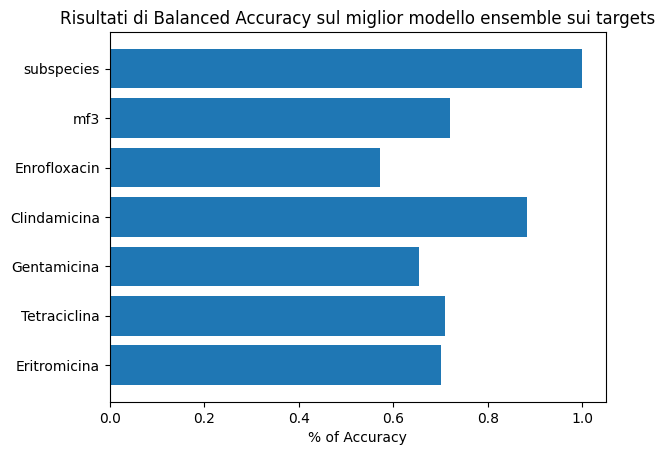

In [ ]:
# bars are by default width 0.8, so we'll add 0.1 to the left coordinates
# so that each bar is centered
y_pos = np.arange(len(target_list))

# plot bars with left x-coordinates [xs], heights [num_oscars]
plt.barh(y_pos, score_best, align='center')
# label x-axis with movie names at bar centers
plt.yticks(y_pos, target_list)
plt.xlabel("% of Accuracy")
plt.title("Risultati di Balanced Accuracy sul miglior modello ensemble sui targets")
plt.show()